Candidate Assessment - Advanced ECG Analysis and Deep Learning

Part 1: Dataset Exploration and Baseline Analysis (25 points)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd "/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model/"

/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

Load data

In [ ]:
# --- Load Data ---
path = './'

df = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)

agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)

Sample Size

In [ ]:
sample_size = len(df)
print(f"Sample Size: {sample_size}")

Sample Size: 21799


Plot demographic distribution

In [ ]:
def plot_age_distribution(df):

    plt.figure(figsize=(10, 6))
    sns.histplot(df['age'], bins=30, kde=True)
    plt.title('Age Distribution of Patients')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    plt.close()

In [ ]:
def plot_sex_distribution(df):

    plt.figure(figsize=(8, 5))
    sex_labels = df['sex'].map({0: 'Male', 1: 'Female'})
    sns.countplot(x=sex_labels)
    plt.title('Sex Distribution of Patients')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.show()
    plt.close()

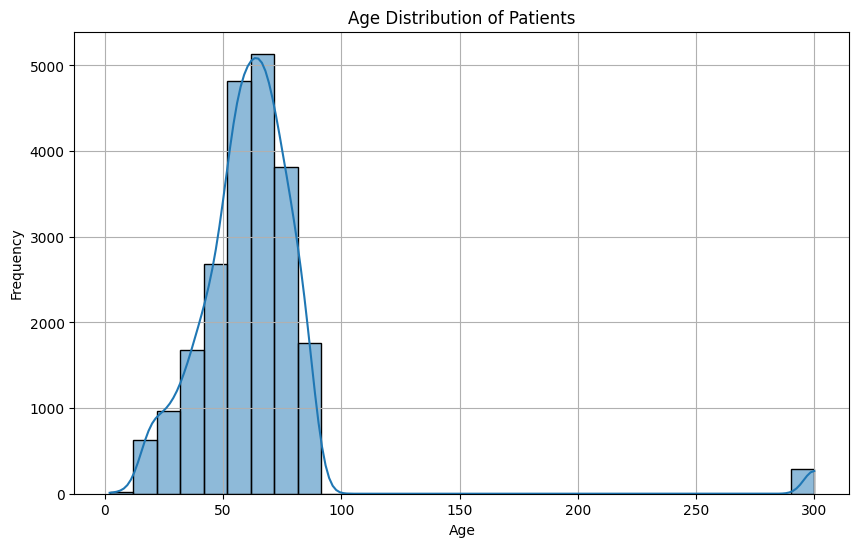

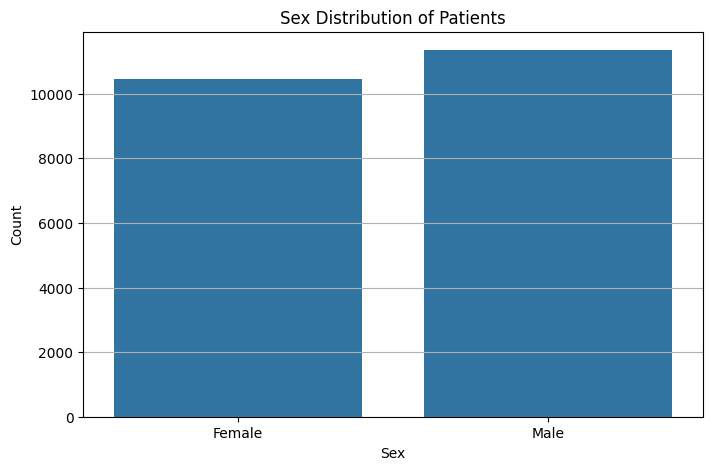

In [ ]:
plot_age_distribution(df.copy())

plot_sex_distribution(df.copy())

Recording parameters

Available Sampling Rates: 100 Hz (Low Resolution), 500 Hz (High Resolution)

Recording Device Distribution:
device
CS100    3    6140
CS-12         4048
AT-6 C 5.5    3950
CS-12   E     2878
AT-6     6    2273
AT-60    3     966
AT-6 C 5.8     824
AT-6 C         514
AT-6 C 5.0      80
AT-6 C 5.3      67
AT-6 C 5.6      59
Name: count, dtype: int64


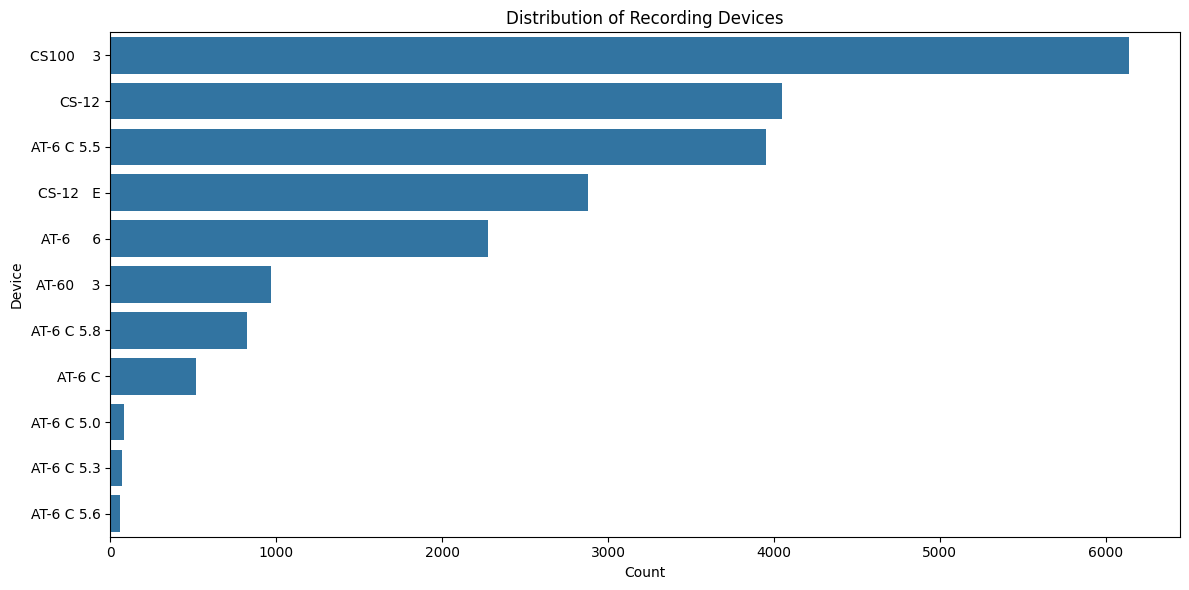

In [ ]:
sampling_rates = []
if 'filename_lr' in df.columns:
    sampling_rates.append('100 Hz (Low Resolution)')
if 'filename_hr' in df.columns:
    sampling_rates.append('500 Hz (High Resolution)')

print(f"Available Sampling Rates: {', '.join(sampling_rates)}")

# Device
print("\nRecording Device Distribution:")
print(df['device'].value_counts())

# Plot device distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='device', data=df, order=df['device'].value_counts().index)
plt.title('Distribution of Recording Devices')
plt.xlabel('Count')
plt.ylabel('Device')
plt.tight_layout()
plt.show()
plt.close()

Plot class distribution

In [ ]:
def plot_diagnostic_superclass_distribution(df):

    plt.figure(figsize=(12, 7))
    sns.countplot(y='diagnostic_superclass', data=df, order=df['diagnostic_superclass'].value_counts().index)
    plt.title('Distribution of Diagnostic Superclasses')
    plt.xlabel('Count')
    plt.ylabel('Diagnostic Superclass')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
df['diagnostic_superclass']

,diagnostic_superclass
ecg_id,
1,[NORM]
2,[NORM]
3,[NORM]
4,[NORM]
5,[NORM]
...,...
21833,[STTC]
21834,[NORM]
21835,[STTC]


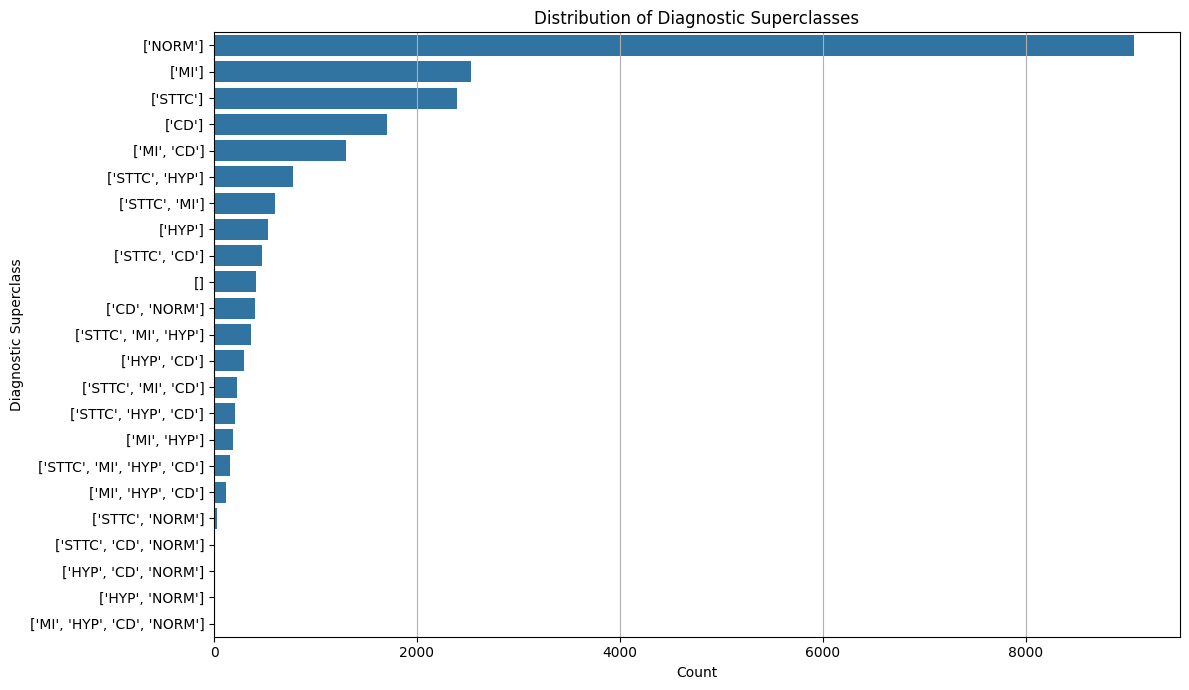

In [ ]:
plot_diagnostic_superclass_distribution(df.copy())

In [ ]:
empty_count = df['diagnostic_superclass'].apply(lambda x: len(x) == 0).sum()
print(f"Number of patients with empty diagnosis: {empty_count}")

Number of patients with empty diagnosis: 411


In [ ]:
# Returns the number of rows where the list is exactly ['NORM']
exact_norm_count = df['diagnostic_superclass'].apply(lambda x: x == ['NORM']).sum()

print(f"Patients with ONLY NORM: {exact_norm_count}")

Patients with ONLY NORM: 9069


ECG quality assessment

In [ ]:
def analyze_data_quality(df):
    # 1. Missing Data Analysis
    print("1. Missing Data Analysis")

    standard_nulls = df.isnull().sum()

    empty_lists = pd.Series(0, index=df.columns)
    for col in df.select_dtypes(include=['object']):
        # Count rows where the value is a list AND has length 0
        empty_lists[col] = df[col].apply(
            lambda x: isinstance(x, list) and len(x) == 0
        ).sum()

    total_missing = standard_nulls + empty_lists
    missing_percentages = (total_missing / len(df)) * 100

    missing_data = pd.DataFrame({
        'Total Missing': total_missing,
        'Percentage': missing_percentages
    })

    missing_data = missing_data[missing_data['Total Missing'] > 0].sort_values(by='Percentage', ascending=False)

    if not missing_data.empty:
        print(missing_data)
    else:
        print("No missing data (nulls or empty lists) found.")
    print("-" * 30)


    # 2. Noise Level Analysis
    print("2. Noise & Quality Indicators")

    noise_columns = [
        'baseline_drift',
        'static_noise',
        'burst_noise',
        'electrodes_problems',
        'extra_beats',
        'pacemaker'
    ]

    for col in noise_columns:
        non_null_count = df[col].count()
        percentage = (non_null_count / len(df)) * 100
        print(f"Records with {col}: {non_null_count} ({percentage:.2f}%)")

In [ ]:
analyze_data_quality(df.copy())

1. Missing Data Analysis
                       Total Missing  Percentage
electrodes_problems            21769   99.862379
infarction_stadium2            21696   99.527501
pacemaker                      21508   98.665076
burst_noise                    21186   97.187944
baseline_drift                 20201   92.669389
extra_beats                    19850   91.059223
static_noise                   18539   85.045186
infarction_stadium1            16187   74.255700
height                         14825   68.007707
weight                         12378   56.782421
validated_by                    9378   43.020322
heart_axis                      8468   38.845819
nurse                           1473    6.757191
diagnostic_superclass            411    1.885408
site                              17    0.077985
------------------------------
2. Noise & Quality Indicators
Records with baseline_drift: 1598 (7.33%)
Records with static_noise: 3260 (14.95%)
Records with burst_noise: 613 (2.81%)
Records w

CNN for classificcation

The code here is adapted from: https://github.com/LuZhenHuan/ECG-Classification-Demo

Here we use vanilla CNN to train a classification model


In [3]:
pip install wfdb

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# Setup paths
path = './'
sampling_rate = 500

Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)
print(f"Original X shape: {X.shape}")

# 3. Load SCP Statements for Aggregation
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Create a boolean mask: True if list is NOT empty, False if empty []
non_empty_mask = Y['diagnostic_superclass'].str.len() > 0

# Apply mask to X (Must be done using the boolean array)
X = X[non_empty_mask.values]

# Apply mask to Y
Y = Y[non_empty_mask]

print(f"Filtered X shape: {X.shape}")
print(f"Removed {len(non_empty_mask) - sum(non_empty_mask)} samples with empty labels.")

test_fold = 10
val_fold = 9

train_mask = (Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)
X_train = X[train_mask.values]
Y_train = Y[train_mask].diagnostic_superclass

val_mask = (Y.strat_fold == val_fold)
X_val = X[val_mask.values]
Y_val = Y[val_mask].diagnostic_superclass

test_mask = (Y.strat_fold == test_fold)
X_test = X[test_mask.values]
Y_test = Y[test_mask].diagnostic_superclass

print(f"\nFinal Shapes:")
print(f"Train: X={X_train.shape}, Y={Y_train.shape}")
print(f"Val:   X={X_val.shape},   Y={Y_val.shape}")
print(f"Test:  X={X_test.shape},  Y={Y_test.shape}")

Original X shape: (21799, 5000, 12)
Filtered X shape: (21388, 5000, 12)
Removed 411 samples with empty labels.

Final Shapes:
Train: X=(17084, 5000, 12), Y=(17084,)
Val:   X=(2146, 5000, 12),   Y=(2146,)
Test:  X=(2158, 5000, 12),  Y=(2158,)


In [2]:
import numpy as np
import scipy.signal as signal
from tqdm import tqdm

def normalization(Z):
    mini=Z.min()
    maxi=Z.max()
    return(-1+((Z-mini)*(2))/(maxi-mini))

def filtering(Z):
    mini=Z.min()
    maxi=Z.max()
    signal_bef = np.zeros((len(Z[:])))
    temp = (-1+((Z-mini)*(2))/(maxi-mini))
    signal_bef = temp
    nyquist = 0.5 * 500
    low_cutoff = 0.05 / nyquist
    high_cutoff = 150.0 / nyquist
    new_sampling_frequency = 512
    original_sampling_frequency = 5000
    b, a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
    filtered_signal = signal.lfilter(b, a, signal_bef)
    filtered_signal = signal_bef # Keeping your exact logic here
    resampled_signal = normalization(signal.resample(filtered_signal, int(len(filtered_signal) * (new_sampling_frequency / original_sampling_frequency))))
    if np.all(np.isnan(resampled_signal)):
        resampled_signal = np.random.normal(0,1,(512))
    return(resampled_signal)

def process_dataset(X_data, name):

    num_samples = len(X_data)
    X_processed = np.zeros((num_samples, 512, 12))

    print(f"Processing {name} data...")
    for i in tqdm(range(num_samples)):
        for l in range(12):
            X_processed[i, :, l] = filtering(X_data[i, :, l])

    return X_processed

# 1. Process Train
X_train_processed = process_dataset(X_train, "Train")
np.save('./data_classify/X_train_processed.npy', X_train_processed)

# 2. Process Val
X_val_processed = process_dataset(X_val, "Val")
np.save('./data_classify/X_val_processed.npy', X_val_processed)
# 3. Process Test
X_test_processed = process_dataset(X_test, "Test")
np.save('./data_classify/X_test_processed.npy', X_test_processed)

print("\nProcessing complete.")
print(f"New Train Shape: {X_train_processed.shape}") # Should be (N, 512, 12)
print(f"New Val Shape:   {X_val_processed.shape}")
print(f"New Test Shape:  {X_test_processed.shape}")
print("Files saved")


Processing Train data...


 57%|█████▋    | 9723/17084 [00:38<00:28, 254.89it/s]C:\Users\zijch\AppData\Local\Temp\ipykernel_46192\778319701.py:14: RuntimeWarning: invalid value encountered in divide
  temp = (-1+((Z-mini)*(2))/(maxi-mini))
100%|██████████| 17084/17084 [01:15<00:00, 224.89it/s]


Processing Val data...


100%|██████████| 2146/2146 [00:09<00:00, 222.11it/s]


Processing Test data...


100%|██████████| 2158/2158 [00:10<00:00, 205.52it/s]



Processing complete.
New Train Shape: (17084, 512, 12)
New Val Shape:   (2146, 512, 12)
New Test Shape:  (2158, 512, 12)
Files saved


Some data has more than one label, so here we use one hot code to the label

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

all_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
mlb = MultiLabelBinarizer(classes=all_classes)

mlb.fit([all_classes])

# one hot code
Y_train_bin = mlb.transform(Y_train)
Y_val_bin   = mlb.transform(Y_val)
Y_test_bin  = mlb.transform(Y_test)

print(f"New Y shape: {Y_train_bin.shape}")

New Y shape: (17084, 5)


In [4]:
print(Y_train_bin)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]]


CNN

In [5]:
import sympy
import sympy.printing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve)
from tqdm import tqdm


BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 40
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 5   # [NORM, MI, STTC, CD, HYP]
CLASSES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

class VanillaCNN(nn.Module):
    def __init__(self, input_len, num_classes=5, dropout_p=0.001):
        super(VanillaCNN, self).__init__()

        self.dropout_p = dropout_p

        # 1. Convolutional Blocks (Standard architecture)
        # Input: (Batch, 1, 12, Length)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 3))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 3))
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(1, 4), stride=(1, 3))

        # 2. Auto-Calculate Flatten Size (The "Adaptive" part)
        # We run a dummy pass to see what shape comes out of conv3
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 12, input_len)
            dummy_out = self._forward_features(dummy_input)
            self._linear_input_size = dummy_out.view(-1).shape[0]

        print(f"Model initialized. Input Length: {input_len} -> Flatten Size: {self._linear_input_size}")

        # 3. Fully Connected Layers
        self.fc1 = nn.Linear(self._linear_input_size, 1024)
        self.out = nn.Linear(1024, num_classes)

    def _forward_features(self, x):
        # Helper to run just the conv parts (used for size calc and forward)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=(1, 3), stride=(1, 2))

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=(1, 3), stride=(1, 2))

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=(1, 3), stride=(1, 2))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        output = self.out(x)      # Logits (No Sigmoid here!)
        return output

def prepare_dataloader(X, Y, batch_size, shuffle=False):
   
    if X.shape[2] == 12:
        X = X.transpose(0, 2, 1)

    X = np.expand_dims(X, axis=1)

    tensor_x = torch.tensor(X, dtype=torch.float32)

    if hasattr(Y, 'values'): Y = Y.values
    if hasattr(Y, 'to_numpy'): Y = Y.to_numpy()
    tensor_y = torch.tensor(np.array(Y.tolist()), dtype=torch.float32)

    return DataLoader(TensorDataset(tensor_x, tensor_y), batch_size=batch_size, shuffle=shuffle)

train_loader = prepare_dataloader(X_train_processed, Y_train_bin, BATCH_SIZE, shuffle=True)
val_loader   = prepare_dataloader(X_val_processed,   Y_val_bin,   BATCH_SIZE, shuffle=False)
test_loader  = prepare_dataloader(X_test_processed,  Y_test_bin,  BATCH_SIZE, shuffle=False)

input_length = X_train_processed.shape[1] if X_train_processed.shape[1] != 12 else X_train_processed.shape[2]

model = VanillaCNN(input_len=input_length, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

best_val_auc = 0
all_train_losses = []
all_val_losses = []

print(f"Starting Training on {DEVICE}...")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    all_train_losses.append(avg_train_loss)

    #val
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            val_preds.append(probs.cpu().numpy())
            val_targets.append(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    all_val_losses.append(avg_val_loss)

    val_preds = np.vstack(val_preds)
    val_targets = np.vstack(val_targets)

    try:
        current_auc = roc_auc_score(val_targets, val_preds, average='macro')
    except:
        current_auc = 0.5

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {current_auc:.4f}")

    # Save Best Model
    if current_auc > best_val_auc:
        best_val_auc = current_auc
        torch.save(model.state_dict(), "best_vanilla_cnn.pth")
        print(">>> New Best Model Saved!")

Model initialized. Input Length: 512 -> Flatten Size: 768
Starting Training on cuda...


Epoch 1/40: 100%|██████████| 267/267 [00:01<00:00, 146.74it/s]


Epoch 1 | Train Loss: 0.4502 | Val Loss: 0.3877 | Val AUC: 0.8368
>>> New Best Model Saved!


Epoch 2/40: 100%|██████████| 267/267 [00:01<00:00, 266.99it/s]


Epoch 2 | Train Loss: 0.3727 | Val Loss: 0.3653 | Val AUC: 0.8524
>>> New Best Model Saved!


Epoch 3/40: 100%|██████████| 267/267 [00:00<00:00, 279.37it/s]


Epoch 3 | Train Loss: 0.3530 | Val Loss: 0.3592 | Val AUC: 0.8578
>>> New Best Model Saved!


Epoch 4/40: 100%|██████████| 267/267 [00:00<00:00, 305.16it/s]


Epoch 4 | Train Loss: 0.3409 | Val Loss: 0.3450 | Val AUC: 0.8692
>>> New Best Model Saved!


Epoch 5/40: 100%|██████████| 267/267 [00:00<00:00, 310.21it/s]


Epoch 5 | Train Loss: 0.3218 | Val Loss: 0.3456 | Val AUC: 0.8724
>>> New Best Model Saved!


Epoch 6/40: 100%|██████████| 267/267 [00:00<00:00, 304.69it/s]


Epoch 6 | Train Loss: 0.3113 | Val Loss: 0.3340 | Val AUC: 0.8798
>>> New Best Model Saved!


Epoch 7/40: 100%|██████████| 267/267 [00:00<00:00, 303.08it/s]


Epoch 7 | Train Loss: 0.2991 | Val Loss: 0.3437 | Val AUC: 0.8776


Epoch 8/40: 100%|██████████| 267/267 [00:00<00:00, 304.00it/s]


Epoch 8 | Train Loss: 0.2907 | Val Loss: 0.3358 | Val AUC: 0.8824
>>> New Best Model Saved!


Epoch 9/40: 100%|██████████| 267/267 [00:00<00:00, 316.69it/s]


Epoch 9 | Train Loss: 0.2796 | Val Loss: 0.3418 | Val AUC: 0.8816


Epoch 10/40: 100%|██████████| 267/267 [00:00<00:00, 300.85it/s]


Epoch 10 | Train Loss: 0.2721 | Val Loss: 0.3335 | Val AUC: 0.8795


Epoch 11/40: 100%|██████████| 267/267 [00:00<00:00, 306.64it/s]


Epoch 11 | Train Loss: 0.2583 | Val Loss: 0.3501 | Val AUC: 0.8777


Epoch 12/40: 100%|██████████| 267/267 [00:00<00:00, 306.60it/s]


Epoch 12 | Train Loss: 0.2497 | Val Loss: 0.3683 | Val AUC: 0.8781


Epoch 13/40: 100%|██████████| 267/267 [00:00<00:00, 304.29it/s]


Epoch 13 | Train Loss: 0.2381 | Val Loss: 0.3682 | Val AUC: 0.8756


Epoch 14/40: 100%|██████████| 267/267 [00:00<00:00, 304.74it/s]


Epoch 14 | Train Loss: 0.2234 | Val Loss: 0.3729 | Val AUC: 0.8761


Epoch 15/40: 100%|██████████| 267/267 [00:00<00:00, 293.51it/s]


Epoch 15 | Train Loss: 0.2085 | Val Loss: 0.3759 | Val AUC: 0.8716


Epoch 16/40: 100%|██████████| 267/267 [00:00<00:00, 294.91it/s]


Epoch 16 | Train Loss: 0.1938 | Val Loss: 0.3947 | Val AUC: 0.8708


Epoch 17/40: 100%|██████████| 267/267 [00:00<00:00, 294.24it/s]


Epoch 17 | Train Loss: 0.1819 | Val Loss: 0.4274 | Val AUC: 0.8651


Epoch 18/40: 100%|██████████| 267/267 [00:00<00:00, 293.16it/s]


Epoch 18 | Train Loss: 0.1670 | Val Loss: 0.4769 | Val AUC: 0.8604


Epoch 19/40: 100%|██████████| 267/267 [00:00<00:00, 288.82it/s]


Epoch 19 | Train Loss: 0.1500 | Val Loss: 0.4652 | Val AUC: 0.8562


Epoch 20/40: 100%|██████████| 267/267 [00:00<00:00, 289.41it/s]


Epoch 20 | Train Loss: 0.1335 | Val Loss: 0.5101 | Val AUC: 0.8578


Epoch 21/40: 100%|██████████| 267/267 [00:00<00:00, 302.23it/s]


Epoch 21 | Train Loss: 0.1175 | Val Loss: 0.5273 | Val AUC: 0.8567


Epoch 22/40: 100%|██████████| 267/267 [00:00<00:00, 303.65it/s]


Epoch 22 | Train Loss: 0.0991 | Val Loss: 0.5771 | Val AUC: 0.8498


Epoch 23/40: 100%|██████████| 267/267 [00:00<00:00, 305.45it/s]


Epoch 23 | Train Loss: 0.0836 | Val Loss: 0.6345 | Val AUC: 0.8449


Epoch 24/40: 100%|██████████| 267/267 [00:00<00:00, 309.27it/s]


Epoch 24 | Train Loss: 0.0708 | Val Loss: 0.6824 | Val AUC: 0.8497


Epoch 25/40: 100%|██████████| 267/267 [00:00<00:00, 310.40it/s]


Epoch 25 | Train Loss: 0.0577 | Val Loss: 0.7724 | Val AUC: 0.8437


Epoch 26/40: 100%|██████████| 267/267 [00:00<00:00, 306.48it/s]


Epoch 26 | Train Loss: 0.0483 | Val Loss: 0.8167 | Val AUC: 0.8482


Epoch 27/40: 100%|██████████| 267/267 [00:00<00:00, 309.46it/s]


Epoch 27 | Train Loss: 0.0336 | Val Loss: 0.8820 | Val AUC: 0.8489


Epoch 28/40: 100%|██████████| 267/267 [00:00<00:00, 308.47it/s]


Epoch 28 | Train Loss: 0.0291 | Val Loss: 0.9672 | Val AUC: 0.8489


Epoch 29/40: 100%|██████████| 267/267 [00:00<00:00, 311.28it/s]


Epoch 29 | Train Loss: 0.0231 | Val Loss: 0.9745 | Val AUC: 0.8458


Epoch 30/40: 100%|██████████| 267/267 [00:00<00:00, 307.72it/s]


Epoch 30 | Train Loss: 0.0193 | Val Loss: 1.0398 | Val AUC: 0.8454


Epoch 31/40: 100%|██████████| 267/267 [00:00<00:00, 308.65it/s]


Epoch 31 | Train Loss: 0.0180 | Val Loss: 1.0825 | Val AUC: 0.8433


Epoch 32/40: 100%|██████████| 267/267 [00:00<00:00, 297.53it/s]


Epoch 32 | Train Loss: 0.0232 | Val Loss: 1.0995 | Val AUC: 0.8427


Epoch 33/40: 100%|██████████| 267/267 [00:00<00:00, 295.64it/s]


Epoch 33 | Train Loss: 0.0214 | Val Loss: 1.1431 | Val AUC: 0.8444


Epoch 34/40: 100%|██████████| 267/267 [00:00<00:00, 300.03it/s]


Epoch 34 | Train Loss: 0.0156 | Val Loss: 1.1803 | Val AUC: 0.8458


Epoch 35/40: 100%|██████████| 267/267 [00:00<00:00, 294.90it/s]


Epoch 35 | Train Loss: 0.0094 | Val Loss: 1.2945 | Val AUC: 0.8436


Epoch 36/40: 100%|██████████| 267/267 [00:00<00:00, 299.11it/s]


Epoch 36 | Train Loss: 0.0143 | Val Loss: 1.2127 | Val AUC: 0.8396


Epoch 37/40: 100%|██████████| 267/267 [00:00<00:00, 302.07it/s]


Epoch 37 | Train Loss: 0.0160 | Val Loss: 1.3250 | Val AUC: 0.8431


Epoch 38/40: 100%|██████████| 267/267 [00:00<00:00, 300.50it/s]


Epoch 38 | Train Loss: 0.0216 | Val Loss: 1.3504 | Val AUC: 0.8408


Epoch 39/40: 100%|██████████| 267/267 [00:00<00:00, 291.27it/s]


Epoch 39 | Train Loss: 0.0081 | Val Loss: 1.3885 | Val AUC: 0.8400


Epoch 40/40: 100%|██████████| 267/267 [00:00<00:00, 300.09it/s]


Epoch 40 | Train Loss: 0.0045 | Val Loss: 1.4231 | Val AUC: 0.8453


Evaluation Test Set


FINAL TEST EVALUATION
Pathology  | ACC      PREC     REC      F1       AUC     
-----------------------------------------------------------------
NORM       | 0.8392   0.7660   0.9211   0.8364   0.9217
MI         | 0.8276   0.7225   0.5255   0.6084   0.8726
STTC       | 0.8661   0.8240   0.5662   0.6712   0.9207
CD         | 0.8712   0.8028   0.5827   0.6752   0.8794
HYP        | 0.8837   0.5873   0.1412   0.2277   0.8133


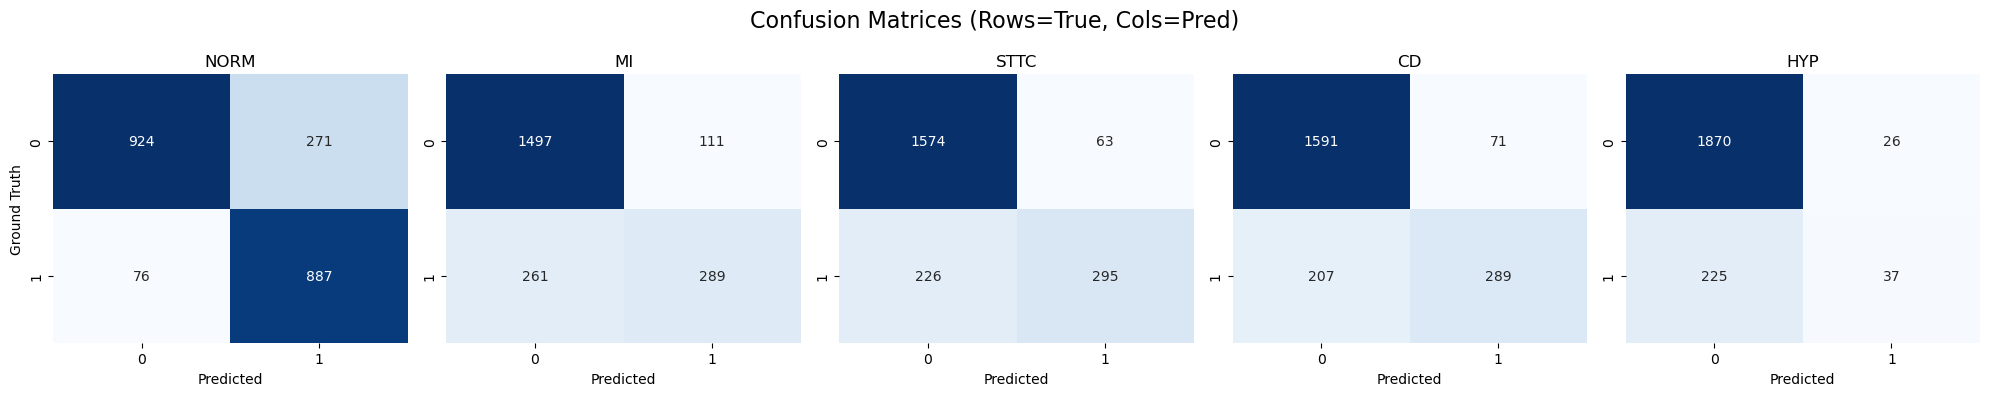

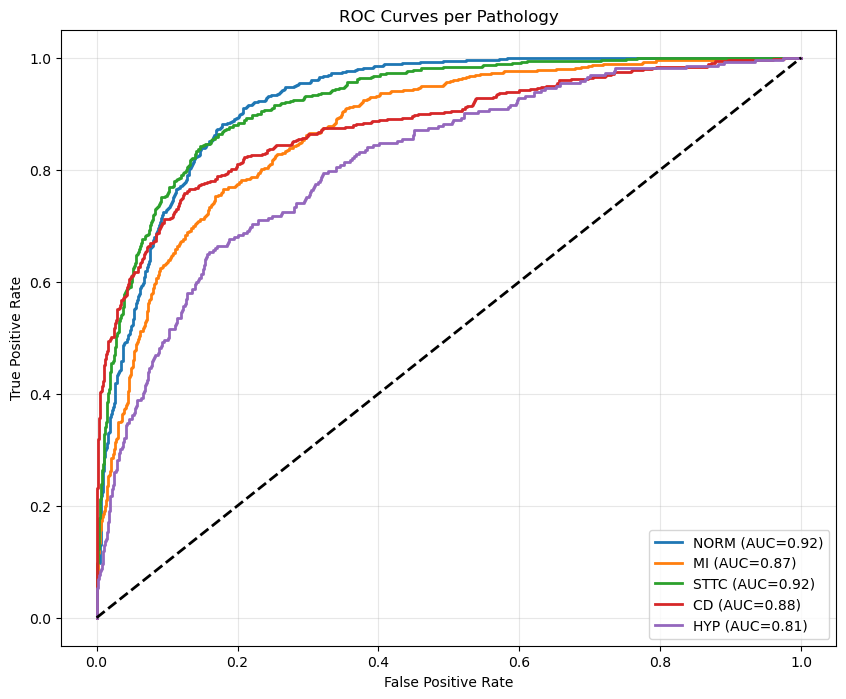

In [6]:
print("\n" + "="*30)
print("FINAL TEST EVALUATION")
print("="*30)

# Load best model
model.load_state_dict(torch.load("best_vanilla_cnn.pth"))
model.eval()

y_true_list = []
y_pred_prob_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)

        y_pred_prob_list.append(probs.cpu().numpy())
        y_true_list.append(labels.numpy())

y_true = np.vstack(y_true_list)
y_pred_prob = np.vstack(y_pred_prob_list)
y_pred_bin = (y_pred_prob > 0.5).astype(int)

print(f"{'Pathology':<10} | {'ACC':<8} {'PREC':<8} {'REC':<8} {'F1':<8} {'AUC':<8}")
print("-" * 65)

metrics = {}
for i, cls in enumerate(CLASSES):
    truth = y_true[:, i]
    pred = y_pred_bin[:, i]
    prob = y_pred_prob[:, i]

    metrics[cls] = {
        'acc': accuracy_score(truth, pred),
        'prec': precision_score(truth, pred, zero_division=0),
        'rec': recall_score(truth, pred, zero_division=0),
        'f1': f1_score(truth, pred, zero_division=0),
        'auc': roc_auc_score(truth, prob) if len(np.unique(truth)) > 1 else 0.5,
        'truth': truth,
        'prob': prob,
        'pred': pred
    }

    m = metrics[cls]
    print(f"{cls:<10} | {m['acc']:.4f}   {m['prec']:.4f}   {m['rec']:.4f}   {m['f1']:.4f}   {m['auc']:.4f}")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Confusion Matrices (Rows=True, Cols=Pred)', fontsize=16)

for i, cls in enumerate(CLASSES):
    cm = confusion_matrix(metrics[cls]['truth'], metrics[cls]['pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(cls)
    axes[i].set_xlabel('Predicted')
    if i == 0: axes[i].set_ylabel('Ground Truth')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
for cls in CLASSES:
    fpr, tpr, _ = roc_curve(metrics[cls]['truth'], metrics[cls]['prob'])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={metrics[cls]['auc']:.2f})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Pathology')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

Part 2: Multi-Lead ECG Autoencoder with Embedding Aggregation

Data split and save in .npy format

In [ ]:
pip install wfdb

In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]

    data = np.array([signal for signal, meta in data])
    return data

path = './'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
#print(X)
print(X.shape)
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold))]
print(X_train.shape)
#Validation
X_val = X[np.where(Y.strat_fold == val_fold)]
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]

# Save with path
np.save('data/X_train.npy', X_train)
np.save('data/X_validation.npy', X_val)
np.save('data/X_test.npy', X_test)

/Users/a86153/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(21799, 5000, 12)
(17418, 5000, 12)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd "/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model/"

/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 39.2 MB/s eta 0:00:00


In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy import signal
from numba import jit, prange
from torch.autograd import Function
from numba import cuda
import math
import torch.cuda
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from scipy.stats import pearsonr
import neurokit2 as nk
import argparse
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

Preprocessing

In [8]:
def normalization(Z):
    mini=Z.min()
    maxi=Z.max()
    return(-1+((Z-mini)*(2))/(maxi-mini))

def filtering(Z):
    mini=Z.min()
    maxi=Z.max()
    signal_bef = np.zeros((len(Z[:])))
    temp = (-1+((Z-mini)*(2))/(maxi-mini))
    signal_bef = temp
    nyquist = 0.5 * 500
    low_cutoff = 0.05 / nyquist
    high_cutoff = 150.0 / nyquist
    new_sampling_frequency = 512
    original_sampling_frequency = 5000
    b, a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
    filtered_signal = signal.lfilter(b, a, signal_bef)
    filtered_signal = signal_bef
    resampled_signal = normalization(signal.resample(filtered_signal, int(len(filtered_signal) * (new_sampling_frequency / original_sampling_frequency))))
    if np.all(np.isnan(resampled_signal)):
        resampled_signal = np.random.normal(0,1,(512))
    return(resampled_signal)


def define_possibility(data):
    P = []
    L = []
    for i in range(1,12):
        if 12%i == 0:
            sous_P = []
            sous_L = []
            for j in range(0,12,i):
                sous_L.append(j)
            L.append(sous_L)
            for j in range(0,len(data[0])+1, int(len(data[0]) / (12 / i))):
                sous_P.append(j)
            sous_P[-1] = 512
            P.append(sous_P)
    return(L,P)

def masking(signal, L, P):
    full_cut_signal = []
    full_full_signal =[]
    for p in range(len(P)):
        cut_signal = np.random.random(signal.shape)
        itp = 0
        it = 0
        for l in range(12):
            try:
                if L[p][it] <= l < L[p][it+1]:
                    pass
                else:
                    itp += 1
                    it  +=1
            except IndexError:
                pass
            cut_signal[P[p][itp]:P[p][itp+1],l] = signal[P[p][itp]:P[p][itp+1],l]
            signal[:,l] = signal[:,l]
        full_cut_signal.append(np.array(cut_signal))
        full_full_signal.append(signal)

    for i in range(12):
        cut_signal = np.random.random(signal.shape)
        cut_signal[:,i] = signal[:,i]
        full_cut_signal.append(np.array(cut_signal))
        full_full_signal.append(signal)
    full_cut_signal = np.array(full_cut_signal)
    full_full_signal = np.array(full_full_signal)
    return(full_cut_signal, full_full_signal)

def creat_dataset(data):
    cut_data = []
    full_data = []
    L,P = define_possibility(data)
    for i in tqdm(range(len(data))):
        cut, full = masking(data[i], L,P)
        cut_data.append(cut)
        full_data.append(full)
    cut_data = np.array(cut_data)
    full_data = np.array(full_data)
    return(np.concatenate(cut_data,0), np.concatenate(full_data,0))


def pre_processing(path, seed):
    data = np.load(path)
    new_data = np.zeros((len(data),512,12))
    for i in tqdm(range(len(data))):
        for l in range(12):
            new_data[i,:,l] = filtering(data[i,:,l])
    data_mask, data_true = creat_dataset(new_data)
    np.random.seed(seed)
    np.random.shuffle(data_mask)
    np.random.seed(seed)
    np.random.shuffle(data_true)
    return(data_mask, data_true)

Load model

In [9]:
class Convolution1D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Convolution1D_layer, self).__init__()
        self.f = out_f
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_f, out_channels=out_f, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm1d(num_features=out_f),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.2)
        )


    def forward(self, x, device):
        b = len(x)
        new_x = torch.tensor(np.zeros((b,self.f, 12, int(x.shape[-1]/2))).astype("float32")).to(device)
        for i in range(12):
            new_x[:,:,i,:] = self.conv(x[:,:,i,:])
        return(new_x)


class Deconvolution1D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Deconvolution1D_layer, self).__init__()
        self.f = out_f
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=in_f, out_channels=out_f, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm1d(num_features=out_f),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.2)
        )


    def forward(self, x, device):
        b = len(x)
        new_x = torch.tensor(np.zeros((b,self.f, 12, int(x.shape[-1]*2))).astype("float32")).to(device)
        for i in range(12):
            new_x[:,:,i,:] = self.deconv(x[:,:,i,:])
        return(new_x)

class Convolution2D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Convolution2D_layer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_f, out_channels=out_f, kernel_size = (13,4), stride = (1,2), padding = (6,1)),
            nn.BatchNorm2d(num_features=out_f),
            nn.LeakyReLU(0.02),
            #nn.Dropout(0.2)
        )


    def forward(self, x):
        new_x = self.conv(x)
        return(new_x)


class Deconvolution2D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Deconvolution2D_layer, self).__init__()
        self.f = out_f
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_f, out_channels=out_f, kernel_size = (13,4), stride = (1,2), padding = (6,1)),
            nn.BatchNorm2d(num_features=out_f),
            nn.LeakyReLU(0.02),
            #nn.Dropout(0.2)
        )


    def forward(self, x):
        new_x = self.deconv(x)
        return(new_x)



class Autoencoder_net(nn.Module):
    def __init__(self):
        super(Autoencoder_net, self).__init__()
        self.first_conv2D = Convolution2D_layer(1,16)
        self.first_conv1D = Convolution1D_layer(1,16)

        self.second_conv2D = Convolution2D_layer(16,32)
        self.second_conv1D = Convolution1D_layer(16,32)

        self.third_conv2D = Convolution2D_layer(32,64)
        self.third_conv1D = Convolution1D_layer(32,64)

        self.fourth_conv2D = Convolution2D_layer(64,128)
        self.fourth_conv1D = Convolution1D_layer(64,128)

        self.first_deconv1D = Deconvolution1D_layer(256,128)
        self.first_deconv2D = Deconvolution2D_layer(256,128)

        self.second_deconv1D = Deconvolution1D_layer(256,64)
        self.second_deconv2D = Deconvolution2D_layer(256,64)

        self.third_deconv1D = Deconvolution1D_layer(128,32)
        self.third_deconv2D = Deconvolution2D_layer(128,32)

        self.fourth_deconv1D = Deconvolution1D_layer(64,1)
        self.fourth_deconv2D = Deconvolution2D_layer(64,1)

        self.final_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size = (13,3), stride = (1,1), padding = (6,1)),
            nn.Tanh(),
        )

        self.transition_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size = (13,3), stride = (1,1), padding = (6,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.02)
        )



    def forward(self, x, device):
        conv2D_1 = self.first_conv2D(x)
        conv1D_1 = self.first_conv1D(x, device)
        conv_1 = torch.concat((conv1D_1,conv2D_1),axis = 1)
        #print("Conv1: ",conv1D_1.shape)
        #print("Conv1: ",conv2D_1.shape)

        conv2D_2 = self.second_conv2D(conv2D_1)
        conv1D_2 = self.second_conv1D(conv1D_1,device)
        #print("Conv2: ",conv1D_2.shape)
        #print("Conv2: ",conv2D_2.shape)
        conv_2 = torch.concat((conv1D_2,conv2D_2),axis = 1)
        #print("Conv2: ",conv_2.shape)

        conv2D_3 = self.third_conv2D(conv2D_2)
        conv1D_3 = self.third_conv1D(conv1D_2,device)
        #print("Conv3: ",conv1D_3.shape)
        #print("Conv3: ",conv2D_3.shape)
        conv_3 = torch.concat((conv1D_3,conv2D_3),axis = 1)
        #print("Conv3: ",conv_3.shape)

        conv2D_4 = self.fourth_conv2D(conv2D_3)
        conv1D_4 = self.fourth_conv1D(conv1D_3,device)
        #print("Conv4: ",conv1D_4.shape)
        #print("Conv4: ",conv2D_4.shape)
        conv_4 = torch.concat((conv1D_4,conv2D_4),axis = 1)
        #print("Conv4: ",conv_4.shape)

        transition = self.transition_block(conv_4)
        #print("Transition: ", transition.shape)


        deconv2D_1 = self.first_deconv2D(conv_4)
        #print("Deconv 1: ",deconv2D_1.shape)
        deconv_1 = torch.concat((deconv2D_1,conv_3),axis = 1)
        #print("Deconv 1 Concat: ",deconv_1.shape)


        deconv2D_2 = self.second_deconv2D(deconv_1)
        #print("Deconv 2: ",deconv2D_2.shape)
        deconv_2 = torch.concat((deconv2D_2,conv_2),axis = 1)
        #print("Deconv 2 Concat: ",deconv_2.shape)

        deconv2D_3 = self.third_deconv2D(deconv_2)
        #print("Deconv 3: ",deconv2D_3.shape)
        deconv_3 = torch.concat((deconv2D_3,conv_1),axis = 1)
        #print("Deconv 3 Concat: ",deconv_3.shape)

        deconv2D_4 = self.fourth_deconv2D(deconv_3)
        #print("Deconv 4: ",deconv2D_4.shape)

        out = self.final_conv(deconv2D_4)
        out = torch.squeeze(out,1)
        return(out)



def load_model():
    Autoencoder = Autoencoder_net()
    return(Autoencoder)

Complete data

In [10]:
def Complete_data(data,Autoencoder,device):
    batch_size = 256
    regenerate_lead = []

    for b in range(0,len(data),batch_size):
        r = data[b:b+batch_size,:,:]
        r = np.expand_dims(r,1).astype("float32")
        r = torch.tensor(r).to(device)
        r = Autoencoder(r, device).to('cpu').detach().numpy()[:,:,:]
        regenerate_lead.append(r)
    regenerate_lead = np.array(np.concatenate(regenerate_lead))
    return(regenerate_lead)

Loss function

In [11]:
class RMSE_Loss(torch.nn.Module):
    def __init__(self, alpha=1):
        super(RMSE_Loss, self).__init__()

    def forward(self, y_true, y_pred):
        loss1 = torch.mean(torch.square(y_true - y_pred), axis = 2)
        loss1= torch.nan_to_num(loss1)
        loss2 = pearson_correlation(y_true, y_pred)
        loss = loss1 - (0.1*loss2)
        return(torch.mean(torch.mean(loss,axis =1)), torch.mean(loss2), torch.mean(loss1))
RMSELoss = RMSE_Loss()

def pearson_correlation(x,y):
    # Ensure that x and y are the same length
    assert len(x) == len(y)

    # Calculate the means of x and y
    x_mean = torch.mean(x, axis = 2)
    y_mean = torch.mean(y, axis = 2)

    # Calculate the variance of x and y
    x_variance = torch.var(x, axis = 2)
    y_variance = torch.var(y, axis = 2)

    # Calculate the standard deviations of x and y
    x_stddev = torch.sqrt(x_variance)
    y_stddev = torch.sqrt(y_variance)



    # Calculate the Pearson correlation coefficient
    r = torch.sum((x - torch.unsqueeze(x_mean, 2)) * (y - torch.unsqueeze(y_mean, 2)), axis = 2 )
    r = r/((len(x[0][0]) * x_stddev * y_stddev))
    r = torch.nan_to_num(r)

    return r


class loss_function(torch.nn.Module):
    def __init__(self, alpha=1):
        super(loss_function, self).__init__()

    def forward(self, y_true, y_pred):
        # Calculate the MSE
        loss1 = torch.mean(torch.square(y_true - y_pred), axis = 2)

        # Calculate the mean correlation of an ECG
        loss2 = pearson_correlation(y_true, y_pred)

        # Calculate the loss
        loss = loss1 - (0.1*loss2)

        # Return the loss, the pearson correlation and the MSE
        return(torch.mean(torch.mean(loss,axis =1)), torch.mean(loss2), torch.mean(loss1))

SoftDTW_functions

In [12]:
# ----------------------------------------------------------------------------------------------------------------------
@cuda.jit
def compute_softdtw_cuda(D, gamma, bandwidth, max_i, max_j, n_passes, R):
    """
    :param seq_len: The length of the sequence (both inputs are assumed to be of the same size)
    :param n_passes: 2 * seq_len - 1 (The number of anti-diagonals)
    """
    # Each block processes one pair of examples
    b = cuda.blockIdx.x
    # We have as many threads as seq_len, because the most number of threads we need
    # is equal to the number of elements on the largest anti-diagonal
    tid = cuda.threadIdx.x

    # Compute I, J, the indices from [0, seq_len)

    # The row index is always the same as tid
    I = tid

    inv_gamma = 1.0 / gamma

    # Go over each anti-diagonal. Only process threads that fall on the current on the anti-diagonal
    for p in range(n_passes):

        # The index is actually 'p - tid' but need to force it in-bounds
        J = max(0, min(p - tid, max_j - 1))

        # For simplicity, we define i, j which start from 1 (offset from I, J)
        i = I + 1
        j = J + 1

        # Only compute if element[i, j] is on the current anti-diagonal, and also is within bounds
        if I + J == p and (I < max_i and J < max_j):
            # Don't compute if outside bandwidth
            if not (abs(i - j) > bandwidth > 0):
                r0 = -R[b, i - 1, j - 1] * inv_gamma
                r1 = -R[b, i - 1, j] * inv_gamma
                r2 = -R[b, i, j - 1] * inv_gamma
                rmax = max(max(r0, r1), r2)
                rsum = math.exp(r0 - rmax) + math.exp(r1 - rmax) + math.exp(r2 - rmax)
                softmin = -gamma * (math.log(rsum) + rmax)
                R[b, i, j] = D[b, i - 1, j - 1] + softmin

        # Wait for other threads in this block
        cuda.syncthreads()

# ----------------------------------------------------------------------------------------------------------------------
@cuda.jit
def compute_softdtw_backward_cuda(D, R, inv_gamma, bandwidth, max_i, max_j, n_passes, E):
    k = cuda.blockIdx.x
    tid = cuda.threadIdx.x

    # Indexing logic is the same as above, however, the anti-diagonal needs to
    # progress backwards
    I = tid

    for p in range(n_passes):
        # Reverse the order to make the loop go backward
        rev_p = n_passes - p - 1

        # convert tid to I, J, then i, j
        J = max(0, min(rev_p - tid, max_j - 1))

        i = I + 1
        j = J + 1

        # Only compute if element[i, j] is on the current anti-diagonal, and also is within bounds
        if I + J == rev_p and (I < max_i and J < max_j):

            if math.isinf(R[k, i, j]):
                R[k, i, j] = -math.inf

            # Don't compute if outside bandwidth
            if not (abs(i - j) > bandwidth > 0):
                a = math.exp((R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) * inv_gamma)
                b = math.exp((R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) * inv_gamma)
                c = math.exp((R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) * inv_gamma)
                E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c

        # Wait for other threads in this block
        cuda.syncthreads()

# ----------------------------------------------------------------------------------------------------------------------
class _SoftDTWCUDA(Function):
    """
    CUDA implementation is inspired by the diagonal one proposed in https://ieeexplore.ieee.org/document/8400444:
    "Developing a pattern discovery method in time series data and its GPU acceleration"
    """

    @staticmethod
    def forward(ctx, D, gamma, bandwidth):
        dev = D.device
        dtype = D.dtype
        gamma = torch.cuda.FloatTensor([gamma])
        bandwidth = torch.cuda.FloatTensor([bandwidth])

        B = D.shape[0]
        N = D.shape[1]
        M = D.shape[2]
        threads_per_block = max(N, M)
        n_passes = 2 * threads_per_block - 1

        # Prepare the output array
        R = torch.ones((B, N + 2, M + 2), device=dev, dtype=dtype) * math.inf
        R[:, 0, 0] = 0

        # Run the CUDA kernel.
        # Set CUDA's grid size to be equal to the batch size (every CUDA block processes one sample pair)
        # Set the CUDA block size to be equal to the length of the longer sequence (equal to the size of the largest diagonal)
        compute_softdtw_cuda[B, threads_per_block](cuda.as_cuda_array(D.detach()),
                                                   gamma.item(), bandwidth.item(), N, M, n_passes,
                                                   cuda.as_cuda_array(R))
        ctx.save_for_backward(D, R.clone(), gamma, bandwidth)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma, bandwidth = ctx.saved_tensors

        B = D.shape[0]
        N = D.shape[1]
        M = D.shape[2]
        threads_per_block = max(N, M)
        n_passes = 2 * threads_per_block - 1

        D_ = torch.zeros((B, N + 2, M + 2), dtype=dtype, device=dev)
        D_[:, 1:N + 1, 1:M + 1] = D

        R[:, :, -1] = -math.inf
        R[:, -1, :] = -math.inf
        R[:, -1, -1] = R[:, -2, -2]

        E = torch.zeros((B, N + 2, M + 2), dtype=dtype, device=dev)
        E[:, -1, -1] = 1

        # Grid and block sizes are set same as done above for the forward() call
        compute_softdtw_backward_cuda[B, threads_per_block](cuda.as_cuda_array(D_),
                                                            cuda.as_cuda_array(R),
                                                            1.0 / gamma.item(), bandwidth.item(), N, M, n_passes,
                                                            cuda.as_cuda_array(E))
        E = E[:, 1:N + 1, 1:M + 1]
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None


# ----------------------------------------------------------------------------------------------------------------------
#
# The following is the CPU implementation based on https://github.com/Sleepwalking/pytorch-softdtw
# Credit goes to Kanru Hua.
# I've added support for batching and pruning.
#
# ----------------------------------------------------------------------------------------------------------------------
@jit(nopython=True, parallel=True)
def compute_softdtw(D, gamma, bandwidth):
    B = D.shape[0]
    N = D.shape[1]
    M = D.shape[2]
    R = np.ones((B, N + 2, M + 2)) * np.inf
    R[:, 0, 0] = 0
    for b in prange(B):
        for j in range(1, M + 1):
            for i in range(1, N + 1):

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                r0 = -R[b, i - 1, j - 1] / gamma
                r1 = -R[b, i - 1, j] / gamma
                r2 = -R[b, i, j - 1] / gamma
                rmax = max(max(r0, r1), r2)
                rsum = np.exp(r0 - rmax) + np.exp(r1 - rmax) + np.exp(r2 - rmax)
                softmin = - gamma * (np.log(rsum) + rmax)
                R[b, i, j] = D[b, i - 1, j - 1] + softmin
    return R

# ----------------------------------------------------------------------------------------------------------------------
@jit(nopython=True, parallel=True)
def compute_softdtw_backward(D_, R, gamma, bandwidth):
    B = D_.shape[0]
    N = D_.shape[1]
    M = D_.shape[2]
    D = np.zeros((B, N + 2, M + 2))
    E = np.zeros((B, N + 2, M + 2))
    D[:, 1:N + 1, 1:M + 1] = D_
    E[:, -1, -1] = 1
    R[:, :, -1] = -np.inf
    R[:, -1, :] = -np.inf
    R[:, -1, -1] = R[:, -2, -2]
    for k in prange(B):
        for j in range(M, 0, -1):
            for i in range(N, 0, -1):

                if np.isinf(R[k, i, j]):
                    R[k, i, j] = -np.inf

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                a0 = (R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) / gamma
                b0 = (R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) / gamma
                c0 = (R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) / gamma
                a = np.exp(a0)
                b = np.exp(b0)
                c = np.exp(c0)
                E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c
    return E[:, 1:N + 1, 1:M + 1]

# ----------------------------------------------------------------------------------------------------------------------
class _SoftDTW(Function):
    """
    CPU implementation based on https://github.com/Sleepwalking/pytorch-softdtw
    """

    @staticmethod
    def forward(ctx, D, gamma, bandwidth):
        dev = D.device
        dtype = D.dtype
        gamma = torch.Tensor([gamma]).to(dev).type(dtype)  # dtype fixed
        bandwidth = torch.Tensor([bandwidth]).to(dev).type(dtype)
        D_ = D.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        R = torch.Tensor(compute_softdtw(D_, g_, b_)).to(dev).type(dtype)
        ctx.save_for_backward(D, R, gamma, bandwidth)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma, bandwidth = ctx.saved_tensors
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        E = torch.Tensor(compute_softdtw_backward(D_, R_, g_, b_)).to(dev).type(dtype)
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None

# ----------------------------------------------------------------------------------------------------------------------
class SoftDTW(torch.nn.Module):
    """
    The soft DTW implementation that optionally supports CUDA
    """

    def __init__(self, use_cuda, gamma=1.0, normalize=False, bandwidth=None, dist_func=None):
        """
        Initializes a new instance using the supplied parameters
        :param use_cuda: Flag indicating whether the CUDA implementation should be used
        :param gamma: sDTW's gamma parameter
        :param normalize: Flag indicating whether to perform normalization
                          (as discussed in https://github.com/mblondel/soft-dtw/issues/10#issuecomment-383564790)
        :param bandwidth: Sakoe-Chiba bandwidth for pruning. Passing 'None' will disable pruning.
        :param dist_func: Optional point-wise distance function to use. If 'None', then a default Euclidean distance function will be used.
        """
        super(SoftDTW, self).__init__()
        self.normalize = normalize
        self.gamma = gamma
        self.bandwidth = 0 if bandwidth is None else float(bandwidth)
        self.use_cuda = use_cuda

        # Set the distance function
        if dist_func is not None:
            self.dist_func = dist_func
        else:
            self.dist_func = SoftDTW._euclidean_dist_func

    def _get_func_dtw(self, x, y):
        """
        Checks the inputs and selects the proper implementation to use.
        """
        bx, lx, dx = x.shape
        by, ly, dy = y.shape
        # Make sure the dimensions match
        assert bx == by  # Equal batch sizes
        assert dx == dy  # Equal feature dimensions

        use_cuda = self.use_cuda

        if use_cuda and (lx > 1024 or ly > 1024):  # We should be able to spawn enough threads in CUDA
                print("SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)")
                use_cuda = False

        # Finally, return the correct function
        return _SoftDTWCUDA.apply if use_cuda else _SoftDTW.apply

    @staticmethod
    def _euclidean_dist_func(x, y):
        """
        Calculates the Euclidean distance between each element in x and y per timestep
        """
        n = x.size(1)
        m = y.size(1)
        d = x.size(2)
        x = x.unsqueeze(2).expand(-1, n, m, d)
        y = y.unsqueeze(1).expand(-1, n, m, d)
        return torch.pow(x - y, 2).sum(3)

    def forward(self, X, Y):
        """
        Compute the soft-DTW value between X and Y
        :param X: One batch of examples, batch_size x seq_len x dims
        :param Y: The other batch of examples, batch_size x seq_len x dims
        :return: The computed results
        """

        # Check the inputs and get the correct implementation
        func_dtw = self._get_func_dtw(X, Y)

        if self.normalize:
            # Stack everything up and run
            x = torch.cat([X, X, Y])
            y = torch.cat([Y, X, Y])
            D = self.dist_func(x, y)
            out = func_dtw(D, self.gamma, self.bandwidth)
            out_xy, out_xx, out_yy = torch.split(out, X.shape[0])
            return out_xy - 1 / 2 * (out_xx + out_yy)
        else:
            D_xy = self.dist_func(X, Y)
            return func_dtw(D_xy, self.gamma, self.bandwidth)

# ----------------------------------------------------------------------------------------------------------------------
def timed_run(a, b, sdtw):
    """
    Runs a and b through sdtw, and times the forward and backward passes.
    Assumes that a requires gradients.
    :return: timing, forward result, backward result
    """
    from timeit import default_timer as timer

    # Forward pass
    start = timer()
    forward = sdtw(a, b)
    end = timer()
    t = end - start

    grad_outputs = torch.ones_like(forward)

    # Backward
    start = timer()
    grads = torch.autograd.grad(forward, a, grad_outputs=grad_outputs)[0]
    end = timer()

    # Total time
    t += end - start

    return t, forward, grads

# ----------------------------------------------------------------------------------------------------------------------
def profile(batch_size, seq_len_a, seq_len_b, dims, tol_backward):
    sdtw = SoftDTW(False, gamma=1.0, normalize=False)
    sdtw_cuda = SoftDTW(True, gamma=1.0, normalize=False)
    n_iters = 6

    print("Profiling forward() + backward() times for batch_size={}, seq_len_a={}, seq_len_b={}, dims={}...".format(batch_size, seq_len_a, seq_len_b, dims))

    times_cpu = []
    times_gpu = []

    for i in range(n_iters):
        a_cpu = torch.rand((batch_size, seq_len_a, dims), requires_grad=True)
        b_cpu = torch.rand((batch_size, seq_len_b, dims))
        a_gpu = a_cpu.cuda()
        b_gpu = b_cpu.cuda()

        # GPU
        t_gpu, forward_gpu, backward_gpu = timed_run(a_gpu, b_gpu, sdtw_cuda)

        # CPU
        t_cpu, forward_cpu, backward_cpu = timed_run(a_cpu, b_cpu, sdtw)

        # Verify the results
        assert torch.allclose(forward_cpu, forward_gpu.cpu())
        assert torch.allclose(backward_cpu, backward_gpu.cpu(), atol=tol_backward)

        if i > 0:  # Ignore the first time we run, in case this is a cold start (because timings are off at a cold start of the script)
            times_cpu += [t_cpu]
            times_gpu += [t_gpu]

    # Average and log
    avg_cpu = np.mean(times_cpu)
    avg_gpu = np.mean(times_gpu)
    print("  CPU:     ", avg_cpu)
    print("  GPU:     ", avg_gpu)
    print("  Speedup: ", avg_cpu / avg_gpu)
    print()

Compute metrics

In [13]:
def MAE(x,y):
    MAE = np.mean(np.absolute(x - y))
    return(MAE)
def RMSE(x,y):
    RMSE = np.sqrt(np.mean((x-y)**2))
    return(RMSE)

def cut_lead(r,t,lead, config):
    list_config = np.array([[[0,42],[42,84],[84,126],[126,168],[168,210],[210,252],[252,294],[294,336],[336,378],[378,420],[420,462],[462,512]],
                  [[0,85],[0,85],[85,170],[85,170],[170,255],[170,255],[255,340],[255,340],[340,425],[340,425],[425,512],[425,512]],
                  [[0,128],[0,128],[0,128],[128,256],[128,256],[128,256],[256,384],[256,384],[256,384],[384,512],[384,512],[384,512]],
                  [[0,170],[0,170],[0,170],[0,170],[170,340],[170,340],[170,340],[170,340],[340,512],[340,512],[340,512],[340,512]],
                  [[0,256],[0,256],[0,256],[0,256],[0,256],[0,256],[256,512],[256,512],[256,512],[256,512],[256,512],[256,512]]])
    end1, start2 = list_config[config][lead]
    new_r1 = r[:end1]
    new_r2 = r[start2:]
    new_r = np.concatenate([new_r1, new_r2])
    new_t1 = t[:end1]
    new_t2 = t[start2:]
    new_t = np.concatenate([new_t1, new_t2])
    return(new_r, new_t)


def calculate_all(config_regenerate, True_):
    dic_lead = {0:"I",1:"II",2:"III",3:"AVR",4:"AVL",5:"AVF",6:"V1",7:"V2",8:"V3",9:"V4",10:"V5",11:"V6"}
    sdtw = SoftDTW(use_cuda=False, gamma=0.1)
    liste_corr = []
    liste_RMSE = []
    liste_MAE = []
    liste_ecg = []
    liste_lead = []
    liste_config = []
    liste_dtw = []
    liste_sot = []
    for ecg in tqdm(range(len(config_regenerate[0]))):
        for lead in range(12):
            for config in range(len(config_regenerate)):

                liste_ecg.append(ecg)
                liste_lead.append(dic_lead[lead])
                liste_config.append(config)

                ### Cut Lead to calculate only on the segment reconstruction ###
                if config < 5 :
                    r, t = cut_lead(config_regenerate[config,ecg,lead,:], True_[config,ecg,lead,:],lead, config )
                    rr = torch.tensor(np.expand_dims(np.expand_dims(r,0),1))
                    tt = torch.tensor(np.expand_dims(np.expand_dims(t,0),1))

                    liste_dtw.append(np.round(sdtw(rr,tt)[0].numpy()/len(r),3))
                    liste_corr.append(np.round(pearsonr(r,t)[0],3))
                    liste_MAE.append(np.round(MAE(r,t),3))
                    liste_RMSE.append(np.round(RMSE(r,t),3))


                else:
                    r, t = config_regenerate[config,ecg,lead,:], True_[config,ecg,lead,:]
                    rr = torch.tensor(np.expand_dims(np.expand_dims(r,0),1))
                    tt = torch.tensor(np.expand_dims(np.expand_dims(t,0),1))
                    liste_dtw.append(np.round(sdtw(rr,tt)[0].numpy()/len(r),3))

                    liste_corr.append(np.round(pearsonr(config_regenerate[config,ecg,lead,:],True_[config,ecg,lead,:])[0],3))
                    liste_MAE.append(np.round(MAE(config_regenerate[config,ecg,lead,:],True_[config,ecg,lead,:]),3))
                    liste_RMSE.append(np.round(RMSE(config_regenerate[config,ecg,lead,:],True_[config,ecg,lead,:]),3))

    colonnes = ['ECG','Lead','Config','PCC', 'RMSE', 'MAE', 'DTW']
    df = pd.DataFrame(np.array([liste_ecg,liste_lead,liste_config,
                            liste_corr, liste_RMSE, liste_MAE, liste_dtw]).T, columns=colonnes)
    return(df)


def Compute_metrics(path_data, path_model, path_save, sd, dvc):
    ### Load Testing data ###
    X_test, X_test_true = pre_processing(path_data,seed = sd)
    X_test_true = np.swapaxes(X_test_true,1,2)
    X_test = np.swapaxes(X_test,1,2)

    ### Load Trained Model ###
    Autoencoder = load_model()
    weight = torch.load(path_model,map_location=torch.device('cpu'))
    Autoencoder.load_state_dict(weight)
    device = torch.device(dvc)
    Autoencoder = Autoencoder.to(device)

    ### Regenerate lead ###
    X_regenerated = Complete_data(X_test, Autoencoder, device)

    ### Split the dataset in 17 configuration
    config_regenerate = np.zeros((17,int(len(X_test)/17),12,512))
    config_True = np.zeros((17,int(len(X_test_true)/17),12,512))

    it = 0
    ecg = 0
    for i in range(len(X_test)):
        config_regenerate[it,ecg,:,:] = X_regenerated[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1
    it = 0
    ecg = 0
    for i in range(len(X_test_true)):
        config_True[it,ecg,:,:] = X_test_true[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1

    df = calculate_all(config_regenerate, config_True)
    df.to_csv(path_save+"Metrics_ECGrecover.csv")

Compute peaks

In [14]:
def Calculate_peaks(config_regenerate, True_):
    list_config_r = []
    list_lead_r = []
    list_ecg_r = []
    list_heartbeat_r = []
    list_p_r = []
    list_q_r = []
    list_r_r = []
    list_s_r = []
    list_toff_r = []

    list_pamp_r = []
    list_qamp_r = []
    list_ramp_r = []
    list_samp_r = []
    list_toffamp_r = []

    for ecg in tqdm(range(len(config_regenerate[0]))):
        for l in range (12):
            for c in range(17):
                temp_true = True_[c,ecg,l,:]
                temp_regenerated = config_regenerate[c,ecg,l,:]
                _, rpeaks_True = nk.ecg_peaks(temp_true, sampling_rate=50)
                if len(rpeaks_True['ECG_R_Peaks']) != 0:
                    for b in rpeaks_True['ECG_R_Peaks']:
                        try:
                            regenerated_heartbeat = temp_regenerated[b-20:b+30]
                            if len(regenerated_heartbeat ) == 50:
                                regenerated_list = np.concatenate([regenerated_heartbeat,regenerated_heartbeat,regenerated_heartbeat,
                                                                   regenerated_heartbeat])
                                _, rpeaks_regenerated = nk.ecg_peaks(regenerated_list, sampling_rate=50)
                                _, waves_peak_regenerated = nk.ecg_delineate(regenerated_list, rpeaks_regenerated,
                                                                             sampling_rate=50, method="dwt")

                                try:
                                    p_regenerated = waves_peak_regenerated["ECG_P_Peaks"][1]
                                except Exception as e:
                                    p_regenerated = np.nan

                                try:
                                    q_regenerated = waves_peak_regenerated["ECG_Q_Peaks"][1]
                                except Exception as e:
                                    q_regenerated = np.nan

                                try:
                                    r_regenerated = rpeaks_regenerated["ECG_R_Peaks"][1]
                                except Exception as e:
                                    r_regenerated = np.nan

                                try:
                                    s_regenerated = waves_peak_regenerated["ECG_S_Peaks"][1]
                                except Exception as e:
                                    s_regenerated = np.nan

                                try:
                                    toff_regenerated = waves_peak_regenerated["ECG_T_Peaks"][1]
                                except Exception as e:
                                    toff_regenerated = np.nan

                                #### Amplitude ###
                                try:
                                    pamp_regenerated = regenerated_list[waves_peak_regenerated["ECG_P_Peaks"][1]]
                                except Exception as e:
                                    pamp_regenerated = np.nan

                                try:
                                    qamp_regenerated = regenerated_list[waves_peak_regenerated["ECG_Q_Peaks"][1]]
                                except Exception as e:
                                    qamp_regenerated = np.nan

                                try:
                                    ramp_regenerated = regenerated_list[rpeaks_regenerated["ECG_R_Peaks"][1]]
                                except Exception as e:
                                    ramp_regenerated = np.nan

                                try:
                                    samp_regenerated = regenerated_list[waves_peak_regenerated["ECG_S_Peaks"][1]]
                                except Exception as e:
                                    samp_regenerated = np.nan

                                try:
                                    toffamp_regenerated = regenerated_list[waves_peak_regenerated["ECG_T_Offsets"][1]]
                                except Exception as e:
                                    toffamp_regenerated = np.nan




                                list_config_r.append(c)
                                list_lead_r.append(l)
                                list_ecg_r.append(ecg)
                                list_heartbeat_r.append(b)
                                list_p_r.append(p_regenerated)
                                list_q_r.append(q_regenerated)
                                list_r_r.append(r_regenerated)
                                list_s_r.append(s_regenerated)
                                list_toff_r.append(toff_regenerated)

                                list_pamp_r.append(pamp_regenerated)
                                list_qamp_r.append(qamp_regenerated)
                                list_ramp_r.append(ramp_regenerated)
                                list_samp_r.append(samp_regenerated)
                                list_toffamp_r.append(toffamp_regenerated)

                        except Exception as e:
                            list_config_r.append(c)
                            list_lead_r.append(l)
                            list_ecg_r.append(ecg)
                            list_heartbeat_r.append(b)
                            list_p_r.append(np.nan)
                            list_q_r.append(np.nan)
                            list_r_r.append(np.nan)
                            list_s_r.append(np.nan)
                            list_toff_r.append(np.nan)
                            list_pamp_r.append(np.nan)
                            list_qamp_r.append(np.nan)
                            list_ramp_r.append(np.nan)
                            list_samp_r.append(np.nan)
                            list_toffamp_r.append(np.nan)
                else:
                    list_config_r.append(c)
                    list_lead_r.append(l)
                    list_ecg_r.append(ecg)
                    list_heartbeat_r.append(b)
                    list_p_r.append(np.nan)
                    list_q_r.append(np.nan)
                    list_r_r.append(np.nan)
                    list_s_r.append(np.nan)
                    list_toff_r.append(np.nan)
                    list_pamp_r.append(np.nan)
                    list_qamp_r.append(np.nan)
                    list_ramp_r.append(np.nan)
                    list_samp_r.append(np.nan)
                    list_toffamp_r.append(np.nan)

    colonnes = ['Config','Lead','ECG', 'HeartBeat', 'Ppos', 'Qpos', 'Rpos', 'Spos', 'Toffpos',
               'Pamp', 'Qamp', 'Ramp', 'Samp', 'Toffamp']
    df = pd.DataFrame(np.array([list_config_r,list_lead_r,list_ecg_r, list_heartbeat_r,
                                list_p_r, list_q_r, list_r_r, list_s_r, list_toff_r,
                               list_pamp_r, list_qamp_r, list_ramp_r, list_samp_r, list_toffamp_r]).T, columns=colonnes)
    return(df)



def Compute_peaks(path_data, path_model, path_save, sd, dvc):
    ### Load Testing data ###
    X_test, X_test_true = pre_processing(path_data,seed = sd)
    X_test_true = np.swapaxes(X_test_true,1,2)
    X_test = np.swapaxes(X_test,1,2)

    ### Load Trained Model ###
    Autoencoder = load_model()
    weight = torch.load(path_model,map_location=torch.device('cpu'))
    Autoencoder.load_state_dict(weight)
    device = torch.device(dvc)
    Autoencoder = Autoencoder.to(device)

    ### Regenerate lead ###
    X_regenerated = Complete_data(X_test, Autoencoder, device)

    ### Split the dataset in 17 configuration
    config_regenerate = np.zeros((17,int(len(X_test)/17),12,512))
    config_True = np.zeros((17,int(len(X_test_true)/17),12,512))

    it = 0
    ecg = 0
    for i in range(len(X_test)):
        config_regenerate[it,ecg,:,:] = X_regenerated[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1
    it = 0
    ecg = 0
    for i in range(len(X_test_true)):
        config_True[it,ecg,:,:] = X_test_true[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1

    df = Calculate_peaks(config_regenerate, config_True)
    df.to_csv(path_save+ "Peaks_ECGrecover.csv")

Training process

In [15]:
### Load Data ###

def load_Data(path, s, Verbose = False):
    X_train, X_true = pre_processing(path+"X_train.npy",seed = s)
    X_validation, X_validation_true = pre_processing(path+"X_validation.npy",seed = s)

    print("Train data: ", X_train.shape)
    print("True data: ", X_true.shape)
    print("\n")
    print("Validation data: ", X_validation.shape)
    print("Validation True data: ", X_validation_true.shape)
    return(X_train, X_true,X_validation, X_validation_true)


### Train ###

def training(train_set, train_label, validation_set, validation_label, epoch, batch_size, Autoencoder, device, optimizer, scheduler, loss, save_path=''):
    lost_list_train = []
    lost_list_validation =  []
    corr_list_validation = []
    corr_list_train = []
    mse_list_validation = []
    mse_list_train = []
    for e in range(epoch):
        start_time = time.time()
        train_loss = 0.
        validation_loss = 0.
        corr_train = 0.
        corr_validation = 0.
        mse_train = 0.
        mse_validation = 0.
        prec = 0
        it = 0
        for b in range(0,len(train_set), batch_size):
            data = train_set[b:b + batch_size].astype("float32")
            data = np.expand_dims(data,1)
            label = np.array(train_label[b:b + batch_size,:,:])
            data = torch.tensor(data).to(device)
            data = torch.transpose(data,2,3)
            label = torch.tensor(label).to(device)
            label = torch.transpose(label,1,2)

            Autoencoder.zero_grad()
            Xc = Autoencoder(data, device)
            lossMSE, corr, mse  = loss(label,Xc)
            lossMSE.backward()
            optimizer.step()

            # update poarameters for Discriminator net
            corr_train += corr.to('cpu').detach().numpy()
            #corr_train += corr
            mse_train += mse.to('cpu').detach().numpy()
            train_loss += lossMSE.to('cpu').detach().numpy()
            it+=1

        lost_list_train.append(train_loss/it)
        corr_list_train.append(corr_train/it)
        mse_list_train.append(mse_train/it)
        scheduler.step(train_loss)
        it2 = 0
        for b in range(0,len(validation_set), batch_size):
            data = validation_set[b:b + batch_size].astype("float32")
            data = np.expand_dims(data,1)
            label = np.array(validation_label[b:b + batch_size,:,:])
            data = torch.tensor(data).to(device)
            data = torch.transpose(data,2,3)
            label = torch.tensor(label).to(device)
            label = torch.transpose(label,1,2)

            Xc = Autoencoder(data, device)


            lossMSE_validation, corr, mse = loss(label,Xc)
            validation_loss += lossMSE_validation.to('cpu').detach().numpy()
            corr_validation += corr.to('cpu').detach().numpy()
            #corr_test += corr
            mse_validation += mse.to('cpu').detach().numpy()
            it2+=1
        scheduler.step(lossMSE_validation)


        lost_list_validation.append(validation_loss)
        corr_list_validation.append(corr_validation)
        mse_list_validation.append(mse_validation)
        print("Epoch %d: lossTrain: %.3f  lossValidation: %.3f corr_Train: %.3f corr_Validation: %.3f mse_Train: %.3f mse_Validation: %.3f Time: %.3f sec" %
              (e, train_loss/it,
               validation_loss/it2,
               corr_train/it,
               corr_validation/it2,
               mse_train/it,
               mse_validation/it2,
               time.time() - start_time))

        if (e + 1) % 2 == 0 and save_path != '':
            torch.save(Autoencoder.state_dict(), save_path+f"Model_epoch_{e+1}.pth")
            np.save(save_path+f"lost_list_train_epoch_{e+1}.npy",lost_list_train)
            np.save(save_path+f"lost_list_validation_epoch_{e+1}.npy",lost_list_validation)
            np.save(save_path+f"corr_list_train_epoch_{e+1}.npy",corr_list_train)
            np.save(save_path+f"corr_list_validation_epoch_{e+1}.npy",corr_list_validation)
            np.save(save_path+f"mse_list_train_epoch_{e+1}.npy",mse_list_train)
            np.save(save_path+f"mse_list_validation_epoch_{e+1}.npy",mse_list_validation)

        #return(lost_list_train, lost_list_validation, corr_list_train, corr_list_validation,mse_list_train,mse_list_validation)


def Train_model(path, sd, dvc, epoch, batch_size, save_path = ''):

    ### Load Data ###
    print("Load Data")
    X_train, X_true,X_validation, X_validation_true = load_Data(path,sd)

    ### Load Model on GPU ###
    print("Load Model")
    Autoencoder = load_model()
    device = torch.device(dvc)
    Autoencoder = Autoencoder.to(device)

    ### Load loss function ###
    loss_f = loss_function
    loss = loss_f()

    ### Optimizer ###
    optimizer = optim.Adam(Autoencoder.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    print("Train Model")
    training(X_train, X_true, X_validation, X_validation_true, epoch, batch_size, Autoencoder, device, optimizer, scheduler, loss, save_path)


Main training file

In [ ]:
def main(data_path, save_path, seed, device, Train, save_results = "Results/", epoch = 10, batch_size = 5):
    if Train == True:
        print("Train Model")
        Train_model(data_path, seed, device, epoch, batch_size, save_path)
    else:
        print("Compute Metrics")
        Compute_metrics(data_path,save_path+"/Model.pth", save_results, seed, device)
        print("\nCompute Peaks")
        Compute_peaks(data_path,save_path+"/Model.pth", save_results, seed, device)

if __name__ == "__main__":
  parser = argparse.ArgumentParser()

  parser.add_argument('--data_path', type=str)
  parser.add_argument('--save_path', type=str)
  parser.add_argument('--seed', type=int)
  parser.add_argument('--device', type=int)
  parser.add_argument('--save_results', type=str)
  parser.add_argument('--epoch', type=int)
  parser.add_argument('--batch_size', type=int)

  parser.add_argument('--Train', action='store_true')
  parser.add_argument('--Verbose', action='store_true')

  args = parser.parse_args(args=[
      '--data_path', 'data/',
      '--save_path', 'model/',
      '--seed', '42',
      '--device', '0',
      '--Train',
      '--save_results', 'Results/',
      '--epoch', '50',
      '--batch_size', '256',
      '--Train'
  ])
  main(args.data_path, args.save_path, args.seed, args.device, args.Train, args.save_results , args.epoch, args.batch_size)


Train Model
Load Data


100%|██████████| 2183/2183 [00:02<00:00, 777.54it/s]


Train data:  (296106, 512, 12)
True data:  (296106, 512, 12)


Validation data:  (37111, 512, 12)
Validation True data:  (37111, 512, 12)
Load Model
Train Model
Epoch 0: lossTrain: 0.052  lossValidation: 0.030 corr_Train: 0.589 corr_Validation: 0.677 mse_Train: 0.111 mse_Validation: 0.098 Time: 350.317 sec
Epoch 1: lossTrain: 0.024  lossValidation: 0.022 corr_Train: 0.700 corr_Validation: 0.703 mse_Train: 0.094 mse_Validation: 0.092 Time: 348.861 sec
Epoch 2: lossTrain: 0.019  lossValidation: 0.018 corr_Train: 0.716 corr_Validation: 0.712 mse_Train: 0.090 mse_Validation: 0.090 Time: 347.910 sec
Epoch 3: lossTrain: 0.016  lossValidation: 0.017 corr_Train: 0.724 corr_Validation: 0.716 mse_Train: 0.088 mse_Validation: 0.089 Time: 348.297 sec
Epoch 4: lossTrain: 0.014  lossValidation: 0.016 corr_Train: 0.728 corr_Validation: 0.719 mse_Train: 0.087 mse_Validation: 0.088 Time: 348.686 sec
Epoch 5: lossTrain: 0.013  lossValidation: 0.016 corr_Train: 0.732 corr_Validation: 0.721 mse_Train: 0.0

Plot validation loss

In [ ]:
validation_data_path = './data/X_validation.npy'
validation_data = np.load(validation_data_path)
validation_batch_number = int(len(validation_data)*17/256)
print(validation_batch_number)

144


MSE

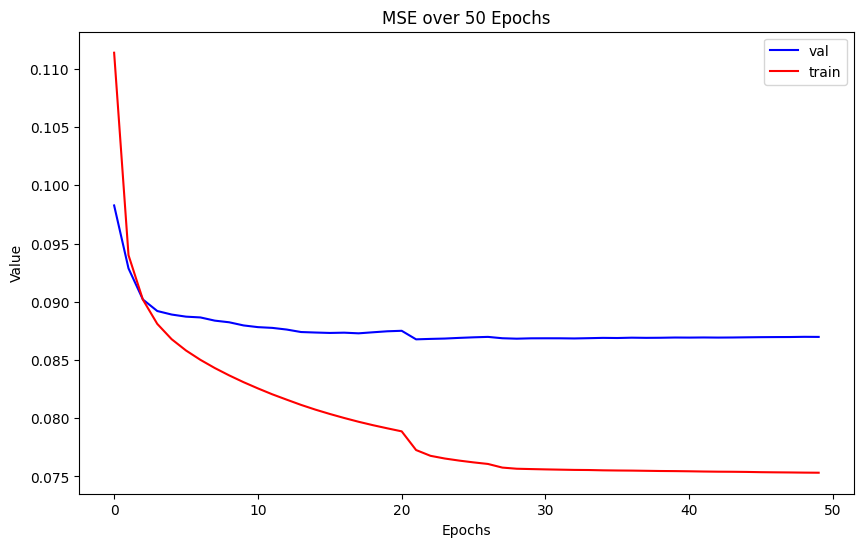

In [ ]:
mse_data_val = np.load('./loss_50epochs/mse_list_validation_epoch_50.npy')
mse_data_train = np.load('./loss_50epochs/mse_list_train_epoch_50.npy')
mse_data_val = mse_data_val/validation_batch_number
mse_data_train = mse_data_train

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(mse_data_val, color='blue', label='val')

plt.plot(mse_data_train, color='red', label='train')

# Add labels, title, and legend
plt.title('MSE over 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Save or show the plot
plt.savefig('./loss_50epochs/MSE_visualization.png')
plt.show()

In [ ]:
print(mse_data_train)

[0.11138623 0.09400338 0.0901828  0.08810241 0.08678593 0.08581476
 0.08501443 0.08431114 0.08367925 0.08309722 0.08256125 0.08205459
 0.08159545 0.08114523 0.08073799 0.08036658 0.08002079 0.07969709
 0.07940308 0.07913287 0.07887264 0.07726849 0.07677333 0.07654005
 0.07636185 0.07620828 0.07607349 0.07576171 0.07566326 0.07563393
 0.07560707 0.07558457 0.07556293 0.0755529  0.07552691 0.07551217
 0.0755024  0.07548539 0.07546874 0.07545947 0.07544386 0.0754243
 0.0754099  0.07540275 0.07538951 0.07536743 0.07535427 0.07534354
 0.07532972 0.07532098]


Pearson correlation

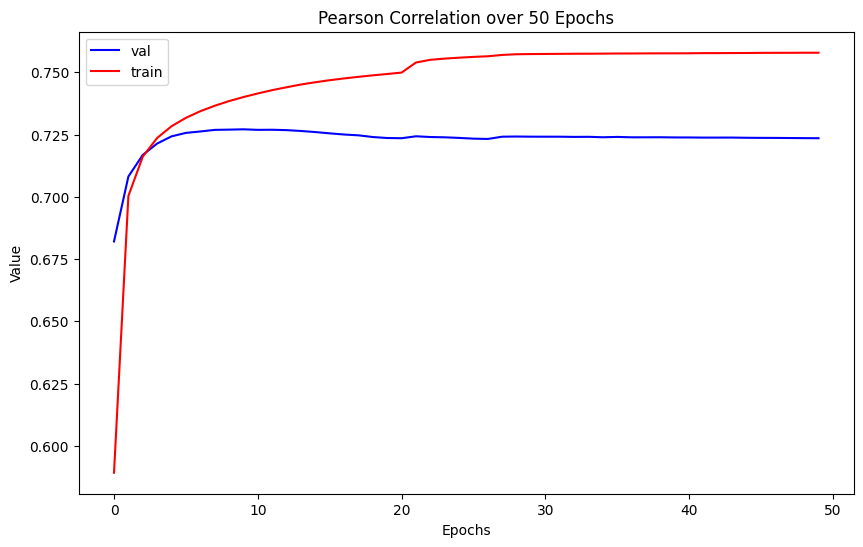

In [ ]:
corr_data_val = np.load('./loss_50epochs/corr_list_validation_epoch_50.npy')
corr_data_train = np.load('./loss_50epochs/corr_list_train_epoch_50.npy')
corr_data_val = corr_data_val/validation_batch_number
corr_data_train = corr_data_train

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(corr_data_val, color='blue', label='val')

plt.plot(corr_data_train, color='red', label='train')

# Add labels, title, and legend
plt.title('Pearson Correlation over 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Save or show the plot
plt.savefig('./loss_50epochs/corr_visualization.png')
plt.show()

Combined loss

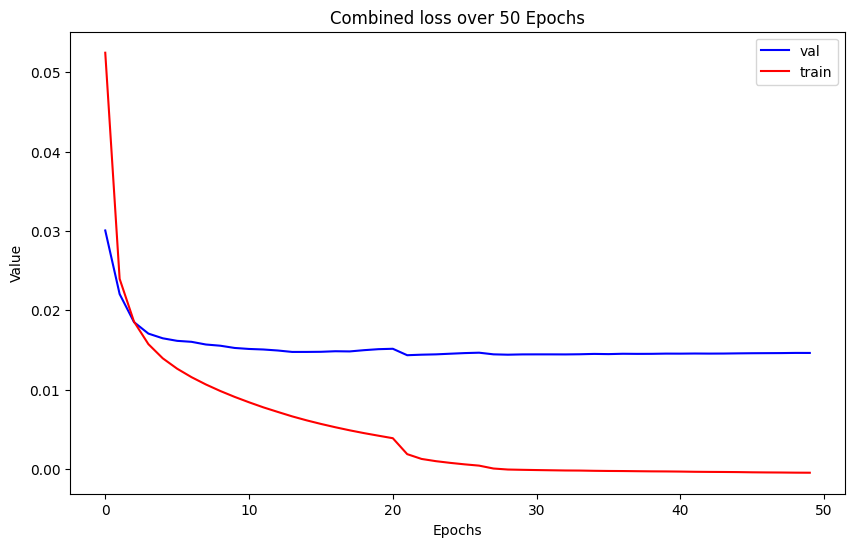

In [ ]:
loss_data_val = np.load('./loss_50epochs/lost_list_validation_epoch_50.npy')
loss_data_train = np.load('./loss_50epochs/lost_list_train_epoch_50.npy')
loss_data_val = loss_data_val/validation_batch_number
loss_data_train = loss_data_train

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(loss_data_val, color='blue', label='val')

plt.plot(loss_data_train, color='red', label='train')

# Add labels, title, and legend
plt.title('Combined loss over 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Save or show the plot
plt.savefig('./loss_50epochs/loss_visualization.png')
plt.show()

Evaluation

In [ ]:
def main(data_path, save_path, seed, device, Train, save_results = "Results/", epoch = 10, batch_size = 5):
    if Train == True:
        print("Train Model")
        Train_model(data_path, seed, device, epoch, batch_size, save_path)
    else:
        print("Compute Metrics")
        Compute_metrics(data_path,save_path+"/Model.pth", save_results, seed, device)

if __name__ == "__main__":
  parser = argparse.ArgumentParser()

  parser.add_argument('--data_path', type=str)
  parser.add_argument('--save_path', type=str)
  parser.add_argument('--seed', type=int)
  parser.add_argument('--device', type=int)
  parser.add_argument('--save_results', type=str)
  parser.add_argument('--epoch', type=int)
  parser.add_argument('--batch_size', type=int)

  parser.add_argument('--Train', action='store_true')
  parser.add_argument('--Verbose', action='store_true')

  args = parser.parse_args(args=[
      '--data_path', 'data/X_test.npy',
      '--save_path', 'model/',
      '--seed', '42',
      '--device', '0',
      '--save_results', 'Results/'
  ])
  main(args.data_path, args.save_path, args.seed, args.device, args.Train, args.save_results , args.epoch, args.batch_size)

Compute Metrics


100%|██████████| 2198/2198 [06:43<00:00,  5.44it/s]


Single lead input evaluation and visualisation

In [16]:
def normalization(Z):
    mini=Z.min()
    maxi=Z.max()
    return(-1+((Z-mini)*(2))/(maxi-mini))

def filtering(Z):
    mini=Z.min()
    maxi=Z.max()
    signal_bef = np.zeros((len(Z[:])))
    temp = (-1+((Z-mini)*(2))/(maxi-mini))
    signal_bef = temp
    nyquist = 0.5 * 500
    low_cutoff = 0.05 / nyquist
    high_cutoff = 150.0 / nyquist
    new_sampling_frequency = 512
    original_sampling_frequency = 5000
    b, a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
    filtered_signal = signal.lfilter(b, a, signal_bef)
    filtered_signal = signal_bef
    resampled_signal = normalization(signal.resample(filtered_signal, int(len(filtered_signal) * (new_sampling_frequency / original_sampling_frequency))))
    if np.all(np.isnan(resampled_signal)):
        resampled_signal = np.random.normal(0,1,(512))
    return(resampled_signal)

def masking_single_lead(single_lead, lead_index, n_leads=12):
    # 1. Get the time steps from the single lead
    time_steps = single_lead.shape[0]

    # 2. Generate the matrix using np.random.random
    # The shape corresponds to (Time, 12) - "like duplicate single lead 12 times"
    masked_signal = np.random.random((time_steps, n_leads))

    # 3. Replace the specific column with the real single lead data
    masked_signal[:, lead_index] = single_lead

    return masked_signal

def calculate_metrics_single_sample(reconstructed_ecg, ground_truth_ecg):

    dic_lead = {0:"I", 1:"II", 2:"III", 3:"AVR", 4:"AVL", 5:"AVF",
                6:"V1", 7:"V2", 8:"V3", 9:"V4", 10:"V5", 11:"V6"}

    # Initialize SoftDTW (ensure inputs are tensors later)
    # Note: If use_cuda=True, inputs must be on GPU. keeping False for safety.
    sdtw = SoftDTW(use_cuda=False, gamma=0.1)

    # Lists to store results
    liste_lead = []
    liste_corr = []  # PCC
    liste_RMSE = []
    liste_MAE = []
    liste_dtw = []

    # Iterate over the 12 leads
    for lead in range(12):

        # Extract the signals for the current lead
        # r = reconstructed, t = true/ground truth
        r = reconstructed_ecg[lead, :]
        t = ground_truth_ecg[lead, :]

        # 1. Pearson Correlation Coefficient (PCC)
        # pearsonr returns (statistic, p-value), we take [0]
        pcc_val = pearsonr(r, t)[0]
        liste_corr.append(np.round(pcc_val, 3))

        # 2. RMSE (Root Mean Square Error)
        # Assuming RMSE function exists, otherwise: np.sqrt(np.mean((r - t)**2))
        rmse_val = RMSE(r, t)
        liste_RMSE.append(np.round(rmse_val, 3))

        # 3. MAE (Mean Absolute Error)
        # Assuming MAE function exists, otherwise: np.mean(np.abs(r - t))
        mae_val = MAE(r, t)
        liste_MAE.append(np.round(mae_val, 3))

        # 4. SoftDTW
        # SoftDTW expects inputs shaped (Batch, Time, Dims) or (Batch, Dims, Time)
        # We prepare (1, 1, 5000) tensors
        rr = torch.tensor(r).float().view(1, 1, -1)
        tt = torch.tensor(t).float().view(1, 1, -1)

        # Calculate DTW and normalize by length
        dtw_val = sdtw(rr, tt)[0].item() / len(r)
        liste_dtw.append(np.round(dtw_val, 3))

        # Store Lead Name
        liste_lead.append(dic_lead[lead])

    # Create DataFrame
    colonnes = ['Lead', 'PCC', 'RMSE', 'MAE', 'DTW']
    df = pd.DataFrame({
        'Lead': liste_lead,
        'PCC': liste_corr,
        'RMSE': liste_RMSE,
        'MAE': liste_MAE,
        'DTW': liste_dtw
    })

    return df

Test set general reconstruction performance

In [17]:
path = './data/X_test.npy'
path_model = 'model/Model.pth'
Autoencoder = load_model()
weight = torch.load(path_model,map_location=torch.device('cpu'))
Autoencoder.load_state_dict(weight)
device = torch.device(0)
Autoencoder = Autoencoder.to(device)
data = np.load(path)
new_data = np.zeros((len(data),512,12))
for i in tqdm(range(len(data))):
  for l in range(12):
    new_data[i,:,l] = filtering(data[i,:,l])

100%|██████████| 2198/2198 [00:07<00:00, 290.18it/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_reconstruction(data, model, device, patient_index, input_lead_index):
    lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    # 1. Prepare Data
    raw_sample = data[patient_index]
    print(raw_sample.shape)
    single_lead_signal = raw_sample[:, input_lead_index]
    print(single_lead_signal.shape)

    masked_lead = masking_single_lead(single_lead_signal, input_lead_index)
    print(masked_lead.shape)

    masked_tensor = torch.tensor(masked_lead.T).float().unsqueeze(0).unsqueeze(0).to(device)
    print(masked_tensor.shape)

    # 3. Inference
    model.eval()
    with torch.no_grad():
        reconstructed_tensor = model(masked_tensor, device)

    # 4. Extract Arrays for Plotting

    ground_truth = raw_sample.T

    reconstructed = reconstructed_tensor.cpu().numpy().squeeze()

    performance_matric = calculate_metrics_single_sample(reconstructed, ground_truth)
    print(performance_matric)

    # 5. Visualization
    fig, axes = plt.subplots(6, 2, figsize=(15, 12), sharex=True)
    fig.suptitle(f'ECG Reconstruction (Patient {patient_index})\nInput: Lead {lead_names[input_lead_index]}', fontsize=16)

    axes = axes.flatten()

    for i in range(12):
        ax = axes[i]

        ax.plot(ground_truth[i], label='Ground Truth', color='black', linewidth=1, alpha=0.6)

        ax.plot(reconstructed[i], label='Reconstructed', color='red', linewidth=1, linestyle='--')

        ax.set_title(f"Lead {lead_names[i]}")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        if i == 0:
            ax.legend(loc="upper right")

        if i == input_lead_index:
            ax.set_facecolor('#eaffea')
            ax.set_title(f"Lead {lead_names[i]} (INPUT)", fontweight='bold', color='green')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

(512, 12)
(512,)
(512, 12)
torch.Size([1, 1, 12, 512])
   Lead    PCC   RMSE    MAE    DTW
0     I  0.677  0.358  0.309  0.128
1    II  0.983  0.054  0.043  0.003
2   III  0.586  0.302  0.258  0.091
3   AVR  0.889  0.321  0.308  0.103
4   AVL  0.333  0.369  0.295  0.136
5   AVF  0.886  0.203  0.189  0.041
6    V1  0.812  0.178  0.125  0.032
7    V2  0.920  0.189  0.173  0.036
8    V3  0.877  0.119  0.092  0.014
9    V4  0.833  0.143  0.122  0.020
10   V5  0.761  0.206  0.175  0.043
11   V6  0.813  0.163  0.133  0.027


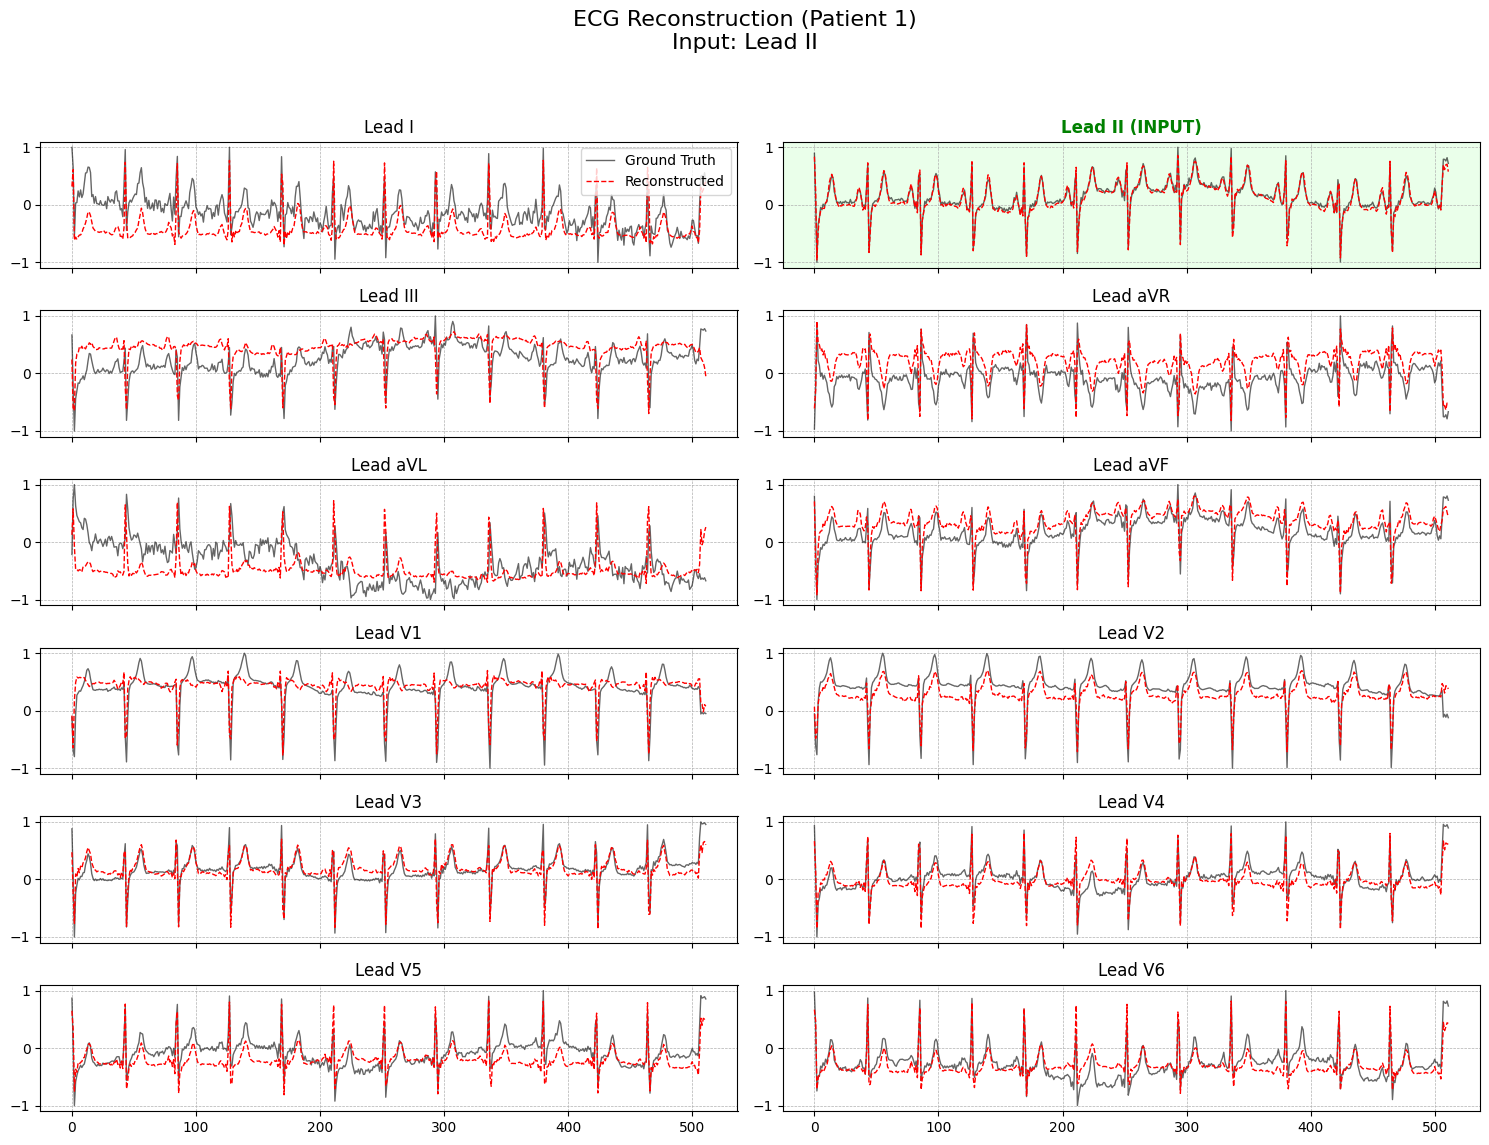

In [ ]:
visualize_reconstruction(new_data, Autoencoder, device, patient_index=1, input_lead_index=1)

Analyse which lead is easier to reconstruct

--- Ranking by Correlation (PCC) ---
Lead
AVR    0.824858
I      0.810956
V5     0.784533
V6     0.771330
V1     0.769234
V2     0.765552
V4     0.756073
II     0.749655
V3     0.729656
AVL    0.629940
AVF    0.595142
III    0.485023
Name: PCC, dtype: float64

--- Ranking by Error (RMSE) ---
Lead
AVR    0.193230
I      0.202847
V5     0.206103
V6     0.210905
V1     0.222256
V2     0.236437
V4     0.237598
II     0.241192
V3     0.271124
AVL    0.288707
AVF    0.307915
III    0.341692
Name: RMSE, dtype: float64


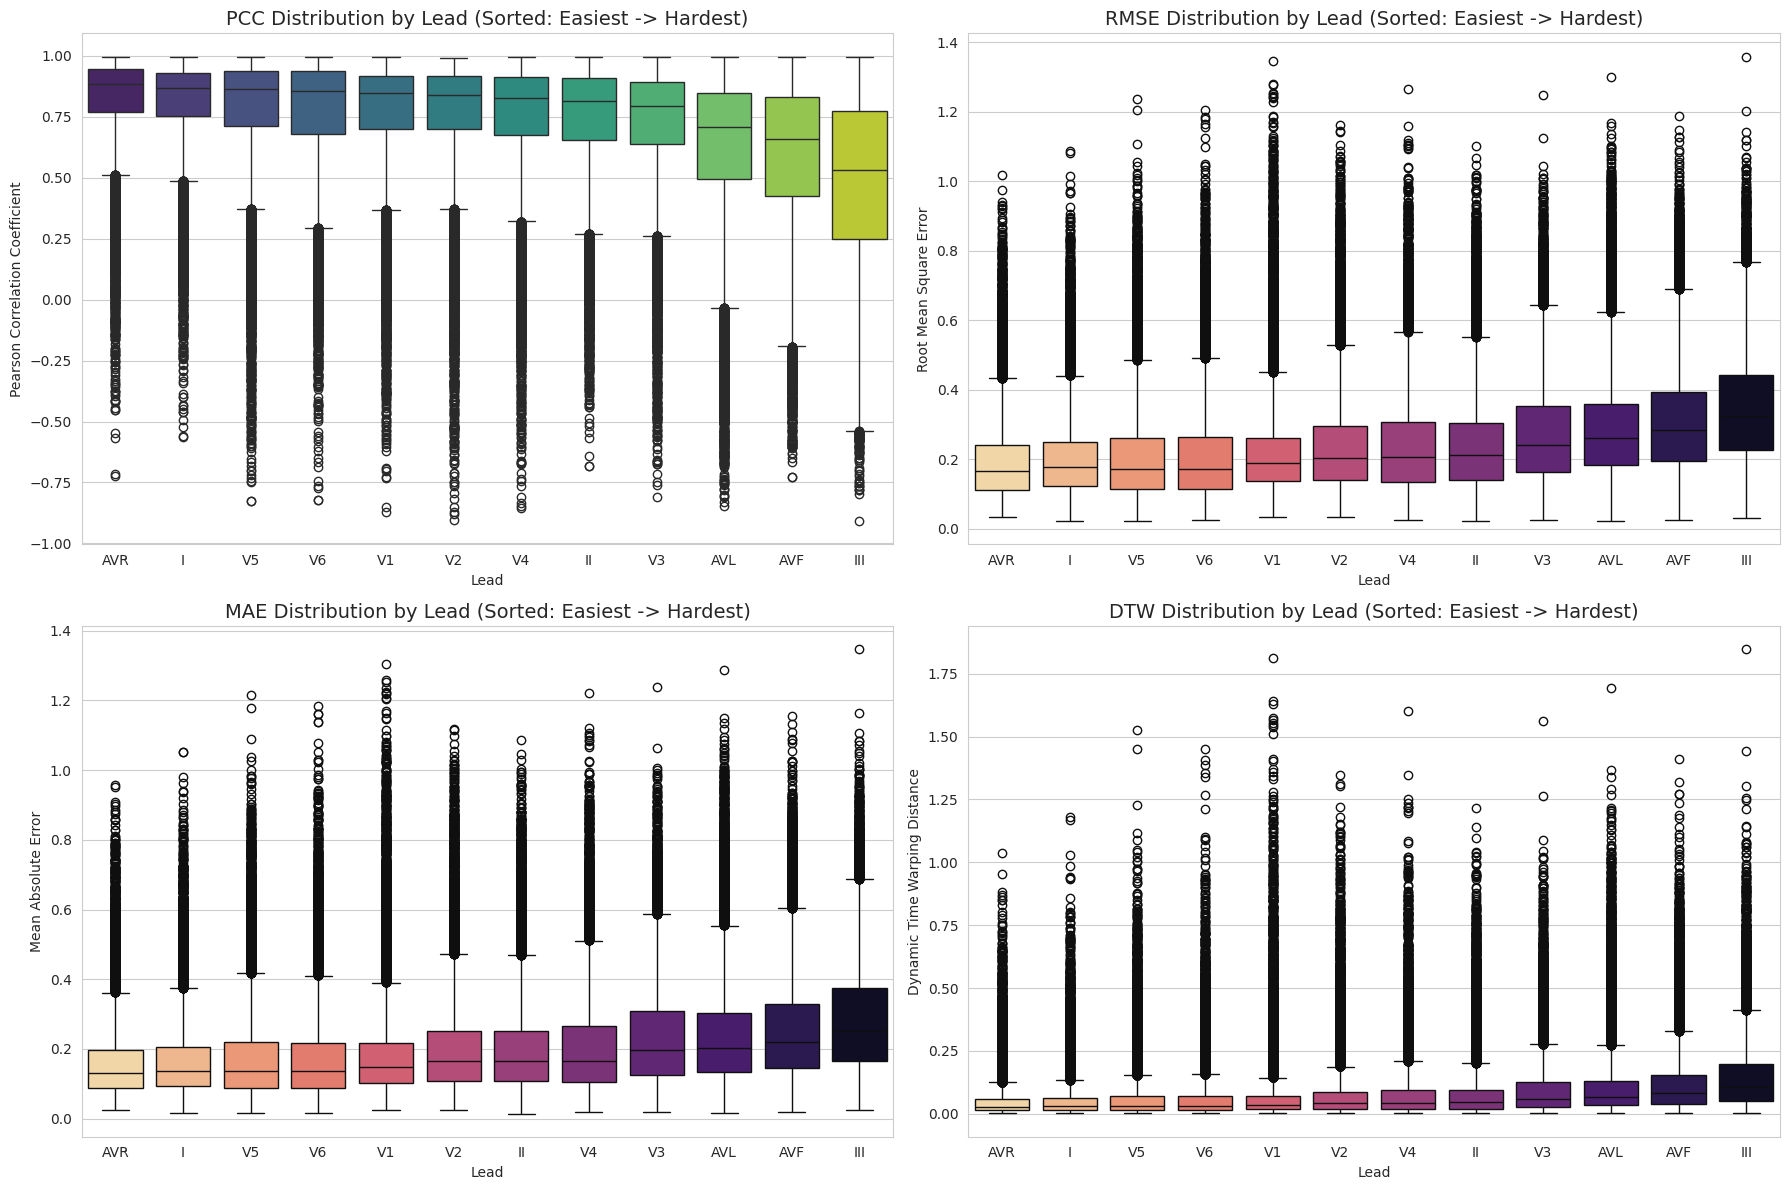

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = './Results/Metrics_ECGrecover.csv'
df = pd.read_csv(file_path)

df_filtered = df[(df['Config'] >= 5) & (df['Config'] <= 16)].copy()

lead_stats = df_filtered.groupby('Lead')[['PCC', 'RMSE', 'MAE', 'DTW']].mean()

pcc_order = lead_stats.sort_values(by='PCC', ascending=False).index.tolist()

rmse_order = lead_stats.sort_values(by='RMSE', ascending=True).index.tolist()

print("--- Ranking by Correlation (PCC) ---")
print(lead_stats.loc[pcc_order, 'PCC'])
print("\n--- Ranking by Error (RMSE) ---")
print(lead_stats.loc[rmse_order, 'RMSE'])

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.boxplot(data=df_filtered, x='Lead', y='PCC', order=pcc_order, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('PCC Distribution by Lead (Sorted: Easiest -> Hardest)', fontsize=14)
axes[0, 0].set_ylabel('Pearson Correlation Coefficient')

sns.boxplot(data=df_filtered, x='Lead', y='RMSE', order=rmse_order, ax=axes[0, 1], palette="magma_r")
axes[0, 1].set_title('RMSE Distribution by Lead (Sorted: Easiest -> Hardest)', fontsize=14)
axes[0, 1].set_ylabel('Root Mean Square Error')

mae_order = lead_stats.sort_values(by='MAE', ascending=True).index.tolist()
sns.boxplot(data=df_filtered, x='Lead', y='MAE', order=mae_order, ax=axes[1, 0], palette="magma_r")
axes[1, 0].set_title('MAE Distribution by Lead (Sorted: Easiest -> Hardest)', fontsize=14)
axes[1, 0].set_ylabel('Mean Absolute Error')

dtw_order = lead_stats.sort_values(by='DTW', ascending=True).index.tolist()
sns.boxplot(data=df_filtered, x='Lead', y='DTW', order=dtw_order, ax=axes[1, 1], palette="magma_r")
axes[1, 1].set_title('DTW Distribution by Lead (Sorted: Easiest -> Hardest)', fontsize=14)
axes[1, 1].set_ylabel('Dynamic Time Warping Distance')

plt.tight_layout()
plt.show()

Embedding analysis

In [66]:
class Convolution1D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Convolution1D_layer, self).__init__()
        self.f = out_f
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_f, out_channels=out_f, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm1d(num_features=out_f),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.2)
        )


    def forward(self, x, device):
        b = len(x)
        new_x = torch.tensor(np.zeros((b,self.f, 12, int(x.shape[-1]/2))).astype("float32")).to(device)
        for i in range(12):
            new_x[:,:,i,:] = self.conv(x[:,:,i,:])
        return(new_x)


class Deconvolution1D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Deconvolution1D_layer, self).__init__()
        self.f = out_f
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=in_f, out_channels=out_f, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm1d(num_features=out_f),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.2)
        )


    def forward(self, x, device):
        b = len(x)
        new_x = torch.tensor(np.zeros((b,self.f, 12, int(x.shape[-1]*2))).astype("float32")).to(device)
        for i in range(12):
            new_x[:,:,i,:] = self.deconv(x[:,:,i,:])
        return(new_x)

class Convolution2D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Convolution2D_layer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_f, out_channels=out_f, kernel_size = (13,4), stride = (1,2), padding = (6,1)),
            nn.BatchNorm2d(num_features=out_f),
            nn.LeakyReLU(0.02),
            #nn.Dropout(0.2)
        )


    def forward(self, x):
        new_x = self.conv(x)
        return(new_x)


class Deconvolution2D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Deconvolution2D_layer, self).__init__()
        self.f = out_f
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_f, out_channels=out_f, kernel_size = (13,4), stride = (1,2), padding = (6,1)),
            nn.BatchNorm2d(num_features=out_f),
            nn.LeakyReLU(0.02),
            #nn.Dropout(0.2)
        )


    def forward(self, x):
        new_x = self.deconv(x)
        return(new_x)



class Autoencoder_net(nn.Module):
    def __init__(self):
        super(Autoencoder_net, self).__init__()
        self.first_conv2D = Convolution2D_layer(1,16)
        self.first_conv1D = Convolution1D_layer(1,16)

        self.second_conv2D = Convolution2D_layer(16,32)
        self.second_conv1D = Convolution1D_layer(16,32)

        self.third_conv2D = Convolution2D_layer(32,64)
        self.third_conv1D = Convolution1D_layer(32,64)

        self.fourth_conv2D = Convolution2D_layer(64,128)
        self.fourth_conv1D = Convolution1D_layer(64,128)

        self.first_deconv1D = Deconvolution1D_layer(256,128)
        self.first_deconv2D = Deconvolution2D_layer(256,128)

        self.second_deconv1D = Deconvolution1D_layer(256,64)
        self.second_deconv2D = Deconvolution2D_layer(256,64)

        self.third_deconv1D = Deconvolution1D_layer(128,32)
        self.third_deconv2D = Deconvolution2D_layer(128,32)

        self.fourth_deconv1D = Deconvolution1D_layer(64,1)
        self.fourth_deconv2D = Deconvolution2D_layer(64,1)

        self.final_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size = (13,3), stride = (1,1), padding = (6,1)),
            nn.Tanh(),
        )

        self.transition_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size = (13,3), stride = (1,1), padding = (6,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.02)
        )



    def forward(self, x, device):
        conv2D_1 = self.first_conv2D(x)
        conv1D_1 = self.first_conv1D(x, device)
        conv_1 = torch.concat((conv1D_1,conv2D_1),axis = 1)
        #print("Conv1: ",conv1D_1.shape)
        #print("Conv1: ",conv2D_1.shape)

        conv2D_2 = self.second_conv2D(conv2D_1)
        conv1D_2 = self.second_conv1D(conv1D_1,device)
        #print("Conv2: ",conv1D_2.shape)
        #print("Conv2: ",conv2D_2.shape)
        conv_2 = torch.concat((conv1D_2,conv2D_2),axis = 1)
        #print("Conv2: ",conv_2.shape)

        conv2D_3 = self.third_conv2D(conv2D_2)
        conv1D_3 = self.third_conv1D(conv1D_2,device)
        #print("Conv3: ",conv1D_3.shape)
        #print("Conv3: ",conv2D_3.shape)
        conv_3 = torch.concat((conv1D_3,conv2D_3),axis = 1)
        #print("Conv3: ",conv_3.shape)

        conv2D_4 = self.fourth_conv2D(conv2D_3)
        conv1D_4 = self.fourth_conv1D(conv1D_3,device)
        #print("Conv4: ",conv1D_4.shape)
        #print("Conv4: ",conv2D_4.shape)
        conv_4 = torch.concat((conv1D_4,conv2D_4),axis = 1)
        #print("Conv4: ",conv_4.shape)

        transition = self.transition_block(conv_4)
        #print("Transition: ", transition.shape)


        deconv2D_1 = self.first_deconv2D(conv_4)
        #print("Deconv 1: ",deconv2D_1.shape)
        deconv_1 = torch.concat((deconv2D_1,conv_3),axis = 1)
        #print("Deconv 1 Concat: ",deconv_1.shape)


        deconv2D_2 = self.second_deconv2D(deconv_1)
        #print("Deconv 2: ",deconv2D_2.shape)
        deconv_2 = torch.concat((deconv2D_2,conv_2),axis = 1)
        #print("Deconv 2 Concat: ",deconv_2.shape)

        deconv2D_3 = self.third_deconv2D(deconv_2)
        #print("Deconv 3: ",deconv2D_3.shape)
        deconv_3 = torch.concat((deconv2D_3,conv_1),axis = 1)
        #print("Deconv 3 Concat: ",deconv_3.shape)

        deconv2D_4 = self.fourth_deconv2D(deconv_3)
        #print("Deconv 4: ",deconv2D_4.shape)

        out = self.final_conv(deconv2D_4)
        out = torch.squeeze(out,1)
        return out, transition



def load_model():
    Autoencoder = Autoencoder_net()
    return(Autoencoder)

In [67]:
path_model = 'model/Model.pth'
Autoencoder = load_model()
weight = torch.load(path_model,map_location=torch.device('cpu'))
Autoencoder.load_state_dict(weight)
device = torch.device(0)
Autoencoder = Autoencoder.to(device)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

def generate_full_lead_tsne(X_data, Y_data, model, device):
    """
    X_data: (N, 512, 12) - Your filtered ECG data (Full 12 leads)
    Y_data: (N, 5) - One-hot encoded labels
    model: Your trained Autoencoder_net
    """
    
    model.eval()
    all_embeddings = []
    
    label_indices = np.argmax(Y_data, axis=1)
    class_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    
    print(f"Processing {len(X_data)} samples using ALL 12 leads...")

    batch_size = 32
    num_samples = len(X_data)
    
    with torch.no_grad():
        for i in tqdm(range(0, num_samples, batch_size)):
            batch_end = min(i + batch_size, num_samples)
            batch_x = X_data[i:batch_end] # Shape: (Batch, 512, 12)
            
            batch_x_transposed = np.transpose(batch_x, (0, 2, 1))
            
            full_input_tensor = torch.tensor(batch_x_transposed).float().unsqueeze(1).to(device)
            
            _, raw_embedding = model(full_input_tensor, device)
            
            embedding_pooled = torch.max(raw_embedding, dim=3)[0]
            
            final_embedding = embedding_pooled.permute(0, 2, 1)
            
            flat_embedding = final_embedding.reshape(len(batch_x), -1)
            
            all_embeddings.append(flat_embedding.cpu().numpy())

    X_embedded = np.concatenate(all_embeddings, axis=0)
    
    print("Running t-SNE on full-lead features...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_embedded)
    
    plt.figure(figsize=(12, 10))
    
    unique_labels = np.unique(label_indices)
    
    colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        indices = label_indices == label
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], 
                    color=color, 
                    label=f"{class_names[label]}",
                    alpha=0.6, s=15)

    plt.title("t-SNE of Latent Features (Full 12-Lead Input)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Pathology")
    plt.grid(True, alpha=0.3)
    plt.show()

In [43]:
X_test_processed.shape

(2158, 512, 12)

In [44]:
Y_test_bin.shape

(2158, 5)

In [ ]:
import numpy as np

label_counts = np.sum(Y_test_bin, axis=1)

single_label_mask = label_counts == 1

X_test_filtered = X_test_processed.copy()[single_label_mask]
Y_test_filtered = Y_test_bin.copy()[single_label_mask]

print(f"Original samples: {len(Y_test_bin)}")
print(f"Filtered samples (single-label only): {len(Y_test_filtered)}")
print(f"Shape of X_test_filtered: {X_test_filtered.shape}")
print(f"Shape of Y_test_filtered: {Y_test_filtered.shape}")

Original samples: 2158
Filtered samples (single-label only): 1650
Shape of X_test_filtered: (1650, 512, 12)
Shape of Y_test_filtered: (1650, 5)


Processing 1650 samples using ALL 12 leads...


100%|██████████| 52/52 [00:02<00:00, 22.68it/s]


Running t-SNE on full-lead features...


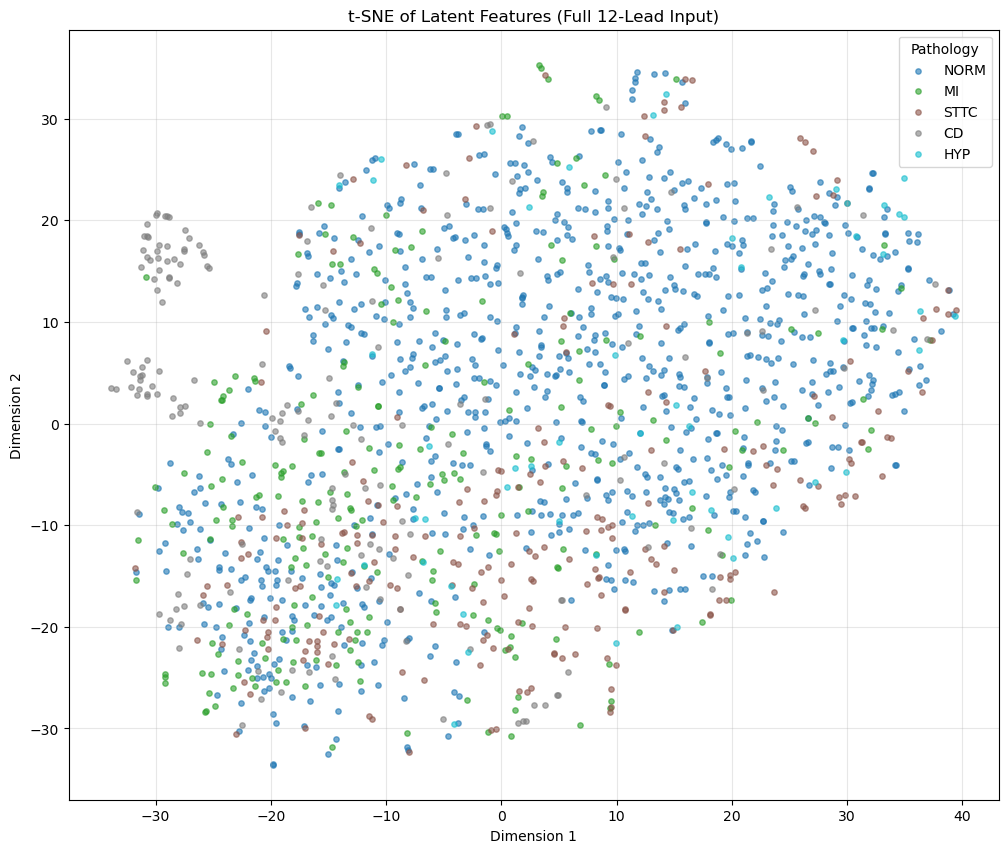

In [69]:
generate_full_lead_tsne(X_test_filtered, Y_test_filtered, Autoencoder, device)

Part 3: PointNet-Inspired 3D Classification